# UK  road accidents and safety data

### Description

Data contains information about the circumstances of personal injury road accidents in Great Britain in 2014. The statistics relate only to personal injury accidents on public roads that are reported to the police, and subsequently recorded, using the STATS19 accident reporting form. Information on damage-only accidents, with no human casualties or accidents on private roads or car parks are not included in this data.

### Importing the data

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import h2o
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.estimators.xgboost import H2OXGBoostEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.automl import H2OAutoML

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn import metrics

from pandas_ml import ConfusionMatrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.utils.multiclass import unique_labels
import time
import matplotlib

from datetime import date
import holidays

In [109]:
plt.style.use("dark_background")
sns.set_style("darkgrid")
sns.set_palette(sns.color_palette("husl"))

## Some useful functions

In [110]:

def conv_tf(l):
    l_b=[]
    for i in l:
        if i[0] == True:
            l_b.append('YES')
        else:
            l_b.append('NO')
    return np.array(l_b)



def conv_b(l):
    l_b=[]
    for i in l:
        if i=='YES':
            l_b.append(1)
        else:
            l_b.append(0)
    return np.array(l_b)

def conv_s(l):
    l_s=[]
    for i in l:
        if i==1:
            l_s.append('YES')
        else:
            l_s.append('NO')
    return np.array(l_s)


def conf_m(t,real_l,pred_l):
    pred_thr=[]
    for i in pred_l:
        if i>=t:
            # print i
            pred_thr.append(1)
        else:
            pred_thr.append(0)
    return confusion_matrix(real_l, pred_thr)


def readable_time(seconds):
    """Returns h:mm:ss formatted time from time in seconds.

    Args:
        seconds (float): Number of seconds to convert to readable time.

    """
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)

    return "%d:%02d:%02d" % (h, m, s)


def confusion_matrix_max(frame, pred_col, real_col, threshold):
    """Creates a confusion matrix based on the truth value of the predictions and a threshold.

    Args:
        frame (H2OFrame, DataFrame): Frame with headers.
        pred_col (str): Name of column with predictions.
        real_col (str): Name of column with actuals.
        threshold (float): Threshold determining vote of prediction column.

    Returns:
        ConfusionMatrix
    """
    predicted = frame[pred_col].apply(lambda row: 1 if row >= threshold else 0)
    real = frame[real_col]
    matrix = ConfusionMatrix(list(real), list(predicted))

    return matrix, matrix.precision, threshold


def draw_roc(frame,model,if_print=True):
    """Plots and ROC curve of a given model and a test frame.

    Args:
        frame (H2OFrame, DataFrame): The test frame.
        model: and H2O trained model.
        if_print (Boolean): A Boolean if needed to print confusion matrices at different thresholds.

    Returns:
        Predictionson the test frame
    """
    # ##############################################################
    # # Run model prediction and assess
    prediction_dnn = model.predict(frame)
    # real = conv_tf(frame['Did_Police_Officer_Attend_Scene_of_Accident'].as_data_frame().values)
    real = frame['Did_Police_Officer_Attend_Scene_of_Accident'].as_data_frame().values

    pred_model = prediction_dnn.as_data_frame()['predict']

    # p_yes_dnn=model.predict(frame).as_data_frame()['True']
    p_yes_dnn=prediction_dnn.as_data_frame()['p1']

    fpr, tpr, thr = roc_curve(real, p_yes_dnn)
    roc_auc = auc(fpr, tpr)

    if if_print == True:
        dtp_dnn=pd.DataFrame()
        for t in thr:
            c_dnn_t=conf_m(t,real,p_yes_dnn)
            tn, fp, fn, tp=c_dnn_t.ravel()
            if (tp+fp)>0:
                print(c_dnn_t, '\n Precsision = ', round(float(tp)/(tp+fp),3) , '\n Threshold = ', round(t,3))
                # dtp_dnn = dtp_dnn.append(
                #     {'Threshold': t, 'TN': tn, 'FP': fp, 'FN': fn, 'TP': tp, 'Precision': round(float(tp) / (tp + fp), 3)},
                #     ignore_index=True)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic {};'.format(model.model_id))
    plt.legend(loc="lower right")
    plt.ion()

    # plt.interactive(False)
    plt.show()
    return p_yes_dnn


def draw_prec_recall(frame,model,if_print=True):
    """Plots and Precision Recall curve of a given model and a test frame.

    Args:
        frame (H2OFrame, DataFrame): The test frame.
        model: and H2O trained model.
        if_print (Boolean): A Boolean if needed to print confusion matrices at different thresholds.

    Returns:
        Predictionson the test frame
    """
    # ##############################################################
    # # Run model prediction and assess
    prediction_dnn = model.predict(frame)
    # real = conv_tf(frame['Did_Police_Officer_Attend_Scene_of_Accident'].as_data_frame().values)
    real = frame['Did_Police_Officer_Attend_Scene_of_Accident'].as_data_frame().values

    pred_model = prediction_dnn.as_data_frame()['predict']

    # p_yes_dnn=model.predict(frame).as_data_frame()['True']
    p_yes_dnn=prediction_dnn.as_data_frame()['p1']

    precision, recall, thr = precision_recall_curve(real, p_yes_dnn)
    # roc_auc = auc(fpr, tpr)

    if if_print == True:
        dtp_dnn=pd.DataFrame()
        for t in thr:
            c_dnn_t=conf_m(t,real,p_yes_dnn)
            tn, fp, fn, tp=c_dnn_t.ravel()
            if (tp+fp)>0:
                print(c_dnn_t, '\n Precsision = ', round(float(tp)/(tp+fp),3) , '\n Threshold = ', round(t,3))
                # dtp_dnn = dtp_dnn.append(
                #     {'Threshold': t, 'TN': tn, 'FP': fp, 'FN': fn, 'TP': tp, 'Precision': round(float(tp) / (tp + fp), 3)},
                #     ignore_index=True)

    plt.figure()
    lw = 2
    plt.step(recall, precision, color='b', alpha = 0.2, where= 'post')
    plt.fill_between(recall,precision, alpha=0.2, color='b')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall (Sensitivity, TPR)')
    plt.ylabel('Precision')
    plt.title('Precision - Recall curve {};'.format(model.model_id))
    plt.legend(loc="lower right")
    plt.ion()

    # plt.interactive(False)
    plt.show()
    return p_yes_dnn


def draw_prec_thr(frame,model,if_print=True):
    """Plots and Precision Recall curve of a given model and a test frame.

    Args:
        frame (H2OFrame, DataFrame): The test frame.
        model: and H2O trained model.
        if_print (Boolean): A Boolean if needed to print confusion matrices at different thresholds.

    Returns:
        Predictionson the test frame
    """
    # ##############################################################
    # # Run model prediction and assess
    prediction_dnn = model.predict(frame)
    # real = conv_tf(frame['Did_Police_Officer_Attend_Scene_of_Accident'].as_data_frame().values)
    real = frame['Did_Police_Officer_Attend_Scene_of_Accident'].as_data_frame().values

    pred_model = prediction_dnn.as_data_frame()['predict']

    # p_yes_dnn=model.predict(frame).as_data_frame()['True']
    p_yes_dnn=prediction_dnn.as_data_frame()['p1']

    precision, recall, thr = precision_recall_curve(real, p_yes_dnn)
    # roc_auc = auc(fpr, tpr)

    if if_print == True:
        dtp_dnn=pd.DataFrame()
        for t in thr:
            c_dnn_t=conf_m(t,real,p_yes_dnn)
            tn, fp, fn, tp=c_dnn_t.ravel()
            if (tp+fp)>0:
                print(c_dnn_t, '\n Precsision = ', round(float(tp)/(tp+fp),3) , '\n Threshold = ', round(t,3))
                # dtp_dnn = dtp_dnn.append(
                #     {'Threshold': t, 'TN': tn, 'FP': fp, 'FN': fn, 'TP': tp, 'Precision': round(float(tp) / (tp + fp), 3)},
                #     ignore_index=True)

    plt.figure()
    lw = 2
    plt.step(thr, precision[:-1], color='r', alpha = 0.2, where= 'post')
    plt.fill_between(thr,precision[:-1], alpha=0.2, color='r')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Threshold')
    plt.ylabel('Precision')
    plt.title('Precision - Threshold curve {};'.format(model.model_id))
    plt.legend(loc="lower right")
    plt.ion()

    # plt.interactive(False)
    plt.show()
    return p_yes_dnn

def plot_confusion_matrix(t,real_l,pred_l, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
    # Compute confusion matrix
    pred_thr=[]
    for i in pred_l:
        if i>=t:
            # print i
            pred_thr.append(1)
        else:
            pred_thr.append(0)

    cm = confusion_matrix(real_l, pred_thr)
    ##################################
    # cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    # classes = classes[unique_labels(real_l, pred_l)]
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

## End Functions
######################################################################
pd.set_option("display.max_columns", 15,"display.width",1000)
pd.set_option("display.max_rows", 20)


def print_stats(thr,real_v, p_yes_gbm):
    cm = conf_m(thr, real_v, p_yes_gbm)
    tn, fp, fn, tp = cm.ravel()
    if (tp + fp) > 0:
        print('Accuracy = ', round((float(tp)+float(tn)) / (float(tp) + float(fp) + float(tn) + float(fn)), 3)*100)
        print('Precsision = ', round(float(tp) / (tp + fp), 3))
        print('Sensitivity = ', round(float(tp) / (tp + fn), 3))
        print('Specificity = ', round(float(tn) / (tn + fp), 3))
        print('NPV = ', round(float(tn) / (tn + fn), 3))        
        print('F1 = ', round(2*float(tp) / (2*float(tp) + float(fp) + float(fn)),2))
        print('MCC = ',round(np.divide(
                                    (float(tp) * float(tn) - float(fp) * float(fn)),
                                    np.sqrt((float(tp) + float(fp))*
                                            (float(tp) + float(fn))*
                                            (float(tn) + float(fp))*
                                            (float(tn) + float(fn)))),4))
        print('Threshold = ', round(t/1000., 3))
        print( cm)
        

In [111]:
df_acc= pd.read_csv('data/DfTRoadSafety_Accidents_2014.csv')
df_acc

,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,...,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location
0,201401BS70001,524600,179020,-0.206443,51.496345,1,3,...,2,2,0,0,1,2,E01002814
1,201401BS70002,525780,178290,-0.189713,51.489523,1,3,...,1,1,0,0,1,2,E01002894
2,201401BS70003,526880,178430,-0.173827,51.490536,1,3,...,1,1,0,0,1,1,E01002822
3,201401BS70004,525580,179080,-0.192311,51.496668,1,3,...,1,1,0,0,1,2,E01002812
4,201401BS70006,527040,179030,-0.171308,51.495892,1,3,...,1,1,0,0,1,1,E01002821
5,201401BS70008,524750,178970,-0.204301,51.495863,1,3,...,1,1,0,0,1,1,E01002814
6,201401BS70009,524950,179240,-0.201326,51.498245,1,3,...,1,2,0,0,1,1,E01002817
7,201401BS70010,523850,181450,-0.216389,51.518349,1,3,...,2,2,0,0,1,1,E01002909
8,201401BS70011,524500,180260,-0.207445,51.507511,1,3,...,1,1,0,0,1,1,E01002871
9,201401BS70013,526450,179230,-0.179731,51.497822,1,3,...,2,2,0,0,1,1,E01002892


In [112]:
# check the Accident_Index is unique
len(df_acc.Accident_Index.unique())

146322

## Exploring the data

The -1's in the data correspond to NULL values, let's substitute and check for nulls

In [113]:
#first check if there are -1's in a string format 
df_acc.eq('-1').sum()

Accident_Index                                 0
Location_Easting_OSGR                          0
Location_Northing_OSGR                         0
Longitude                                      0
Latitude                                       0
Police_Force                                   0
Accident_Severity                              0
Number_of_Vehicles                             0
Number_of_Casualties                           0
Date                                           0
                                              ..
Pedestrian_Crossing-Human_Control              0
Pedestrian_Crossing-Physical_Facilities        0
Light_Conditions                               0
Weather_Conditions                             0
Road_Surface_Conditions                        0
Special_Conditions_at_Site                     0
Carriageway_Hazards                            0
Urban_or_Rural_Area                            0
Did_Police_Officer_Attend_Scene_of_Accident    0
LSOA_of_Accident_Loc

In [114]:
#next check how many -1's are in the data and in which columns prediominantly
df_acc.eq(-1).sum()

Accident_Index                                   0
Location_Easting_OSGR                            0
Location_Northing_OSGR                           0
Longitude                                        0
Latitude                                         0
Police_Force                                     0
Accident_Severity                                0
Number_of_Vehicles                               0
Number_of_Casualties                             0
Date                                             0
                                              ... 
Pedestrian_Crossing-Human_Control                0
Pedestrian_Crossing-Physical_Facilities          0
Light_Conditions                                 0
Weather_Conditions                               0
Road_Surface_Conditions                        222
Special_Conditions_at_Site                       1
Carriageway_Hazards                              1
Urban_or_Rural_Area                              0
Did_Police_Officer_Attend_Scene

In [115]:
# replace and check the replacemnet was correct
df_acc.replace(-1,np.nan, inplace=True)
df_acc.isna().sum()

Accident_Index                                    0
Location_Easting_OSGR                             0
Location_Northing_OSGR                            0
Longitude                                         0
Latitude                                          0
Police_Force                                      0
Accident_Severity                                 0
Number_of_Vehicles                                0
Number_of_Casualties                              0
Date                                              0
                                               ... 
Pedestrian_Crossing-Human_Control                 0
Pedestrian_Crossing-Physical_Facilities           0
Light_Conditions                                  0
Weather_Conditions                                0
Road_Surface_Conditions                         222
Special_Conditions_at_Site                        1
Carriageway_Hazards                               1
Urban_or_Rural_Area                               0
Did_Police_O

The response variable does not have missing data, and there does not seemt to be bad data quality issues except in few columns. Let's chek the data balance:

In [116]:
#Check the third option is abscent 
#from the response variable (as noted in the variable description)
df_acc.Did_Police_Officer_Attend_Scene_of_Accident.unique()

array([2, 1])

In [117]:
# replace 2 with 0 for police not showing up 
df_acc.Did_Police_Officer_Attend_Scene_of_Accident.replace(2,0, inplace=True)
# df_acc.replace({'Did_Police_Officer_Attend_Scene_of_Accident':{1:0}},
#                inplace=True)
# df_acc.replace({'Did_Police_Officer_Attend_Scene_of_Accident':{2:1}},
#                inplace=True)

#check the imbalance
print (df_acc.Did_Police_Officer_Attend_Scene_of_Accident.eq(1).sum(),
       df_acc.Did_Police_Officer_Attend_Scene_of_Accident.eq(0).sum())
print ('Police attended in the {}% of cases'.
       format(round((df_acc.Did_Police_Officer_Attend_Scene_of_Accident.eq(0).sum()/
                     len(df_acc))*100)))

119607 26715
Police attended in the 18.0% of cases


In [118]:
#Create the date time column
df_acc['dt'] = pd.to_datetime(df_acc.Date+' '+df_acc.Time)

In [119]:
df_acc['Month'] = df_acc.dt.dt.month 
df_acc['Hour'] = df_acc.dt.dt.hour
df_acc

,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,...,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location,dt,Month,Hour
0,201401BS70001,524600,179020,-0.206443,51.496345,1,3,...,0.0,1,0,E01002814,2014-09-01 13:21:00,9,13
1,201401BS70002,525780,178290,-0.189713,51.489523,1,3,...,0.0,1,0,E01002894,2014-01-20 23:00:00,1,23
2,201401BS70003,526880,178430,-0.173827,51.490536,1,3,...,0.0,1,1,E01002822,2014-01-21 10:40:00,1,10
3,201401BS70004,525580,179080,-0.192311,51.496668,1,3,...,0.0,1,0,E01002812,2014-01-15 17:45:00,1,17
4,201401BS70006,527040,179030,-0.171308,51.495892,1,3,...,0.0,1,1,E01002821,2014-09-01 08:50:00,9,8
5,201401BS70008,524750,178970,-0.204301,51.495863,1,3,...,0.0,1,1,E01002814,2014-01-17 14:11:00,1,14
6,201401BS70009,524950,179240,-0.201326,51.498245,1,3,...,0.0,1,1,E01002817,2014-10-01 18:25:00,10,18
7,201401BS70010,523850,181450,-0.216389,51.518349,1,3,...,0.0,1,1,E01002909,2014-01-30 17:50:00,1,17
8,201401BS70011,524500,180260,-0.207445,51.507511,1,3,...,0.0,1,1,E01002871,2014-10-01 10:55:00,10,10
9,201401BS70013,526450,179230,-0.179731,51.497822,1,3,...,0.0,1,1,E01002892,2014-05-01 20:26:00,5,20


#### Accident Severity

,Count
Fatal,1658
Serious,20676
Slight,123988


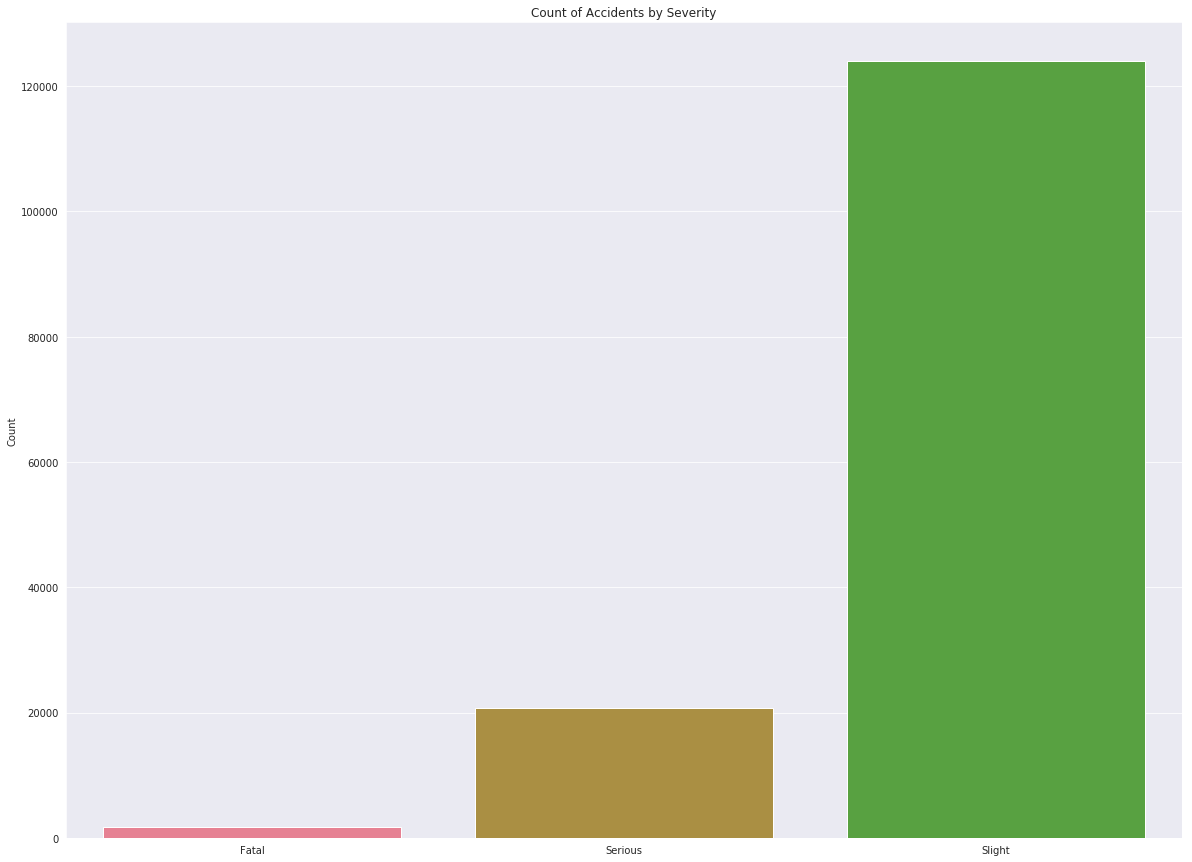

In [120]:
severeity=pd.DataFrame.from_dict(
    {'Fatal':df_acc.Accident_Severity.value_counts()[1],
             'Serious':df_acc.Accident_Severity.value_counts()[2], 
             'Slight':df_acc.Accident_Severity.value_counts()[3]},
    orient='index', columns=['Count'])

plt.figure(2, figsize=(20,15))
sns.barplot(x=severeity.index, y='Count',data=severeity)
plt.title('Count of Accidents by Severity')

severeity


,Accident_Severity,Did_Police_Officer_Attend_Scene_of_Accident,Accident_Index
0,Fatal,NO,20
1,Fatal,YES,1638
2,Serious,NO,1941
3,Serious,YES,18735
4,Slight,NO,24754
5,Slight,YES,99234


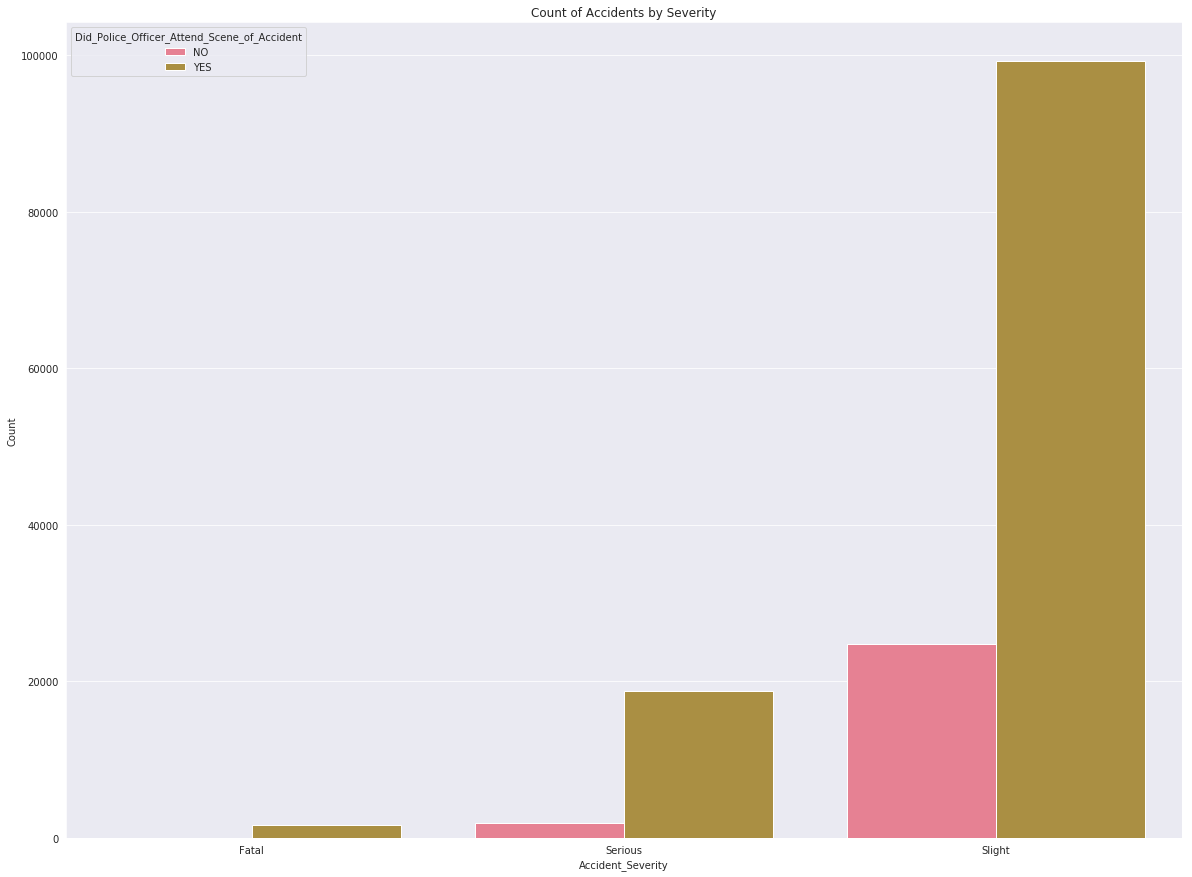

In [121]:
sever_by_attend=df_acc.replace({'Accident_Severity':{1:'Fatal',2:'Serious',3:'Slight'},
              'Did_Police_Officer_Attend_Scene_of_Accident':{0:'NO',1:'YES'}})[
    ['Accident_Severity','Did_Police_Officer_Attend_Scene_of_Accident','Accident_Index']].groupby(
      ['Accident_Severity','Did_Police_Officer_Attend_Scene_of_Accident']).count().reset_index()

plt.figure(2, figsize=(20,15))
sns.barplot(x='Accident_Severity', y='Accident_Index', 
            hue ='Did_Police_Officer_Attend_Scene_of_Accident',
            data=sever_by_attend)
plt.ylabel("Count")
plt.title('Count of Accidents by Severity')

sever_by_attend

Text(0.5, 1.0, 'Percentage of Police Not Attending by Accident Severity')

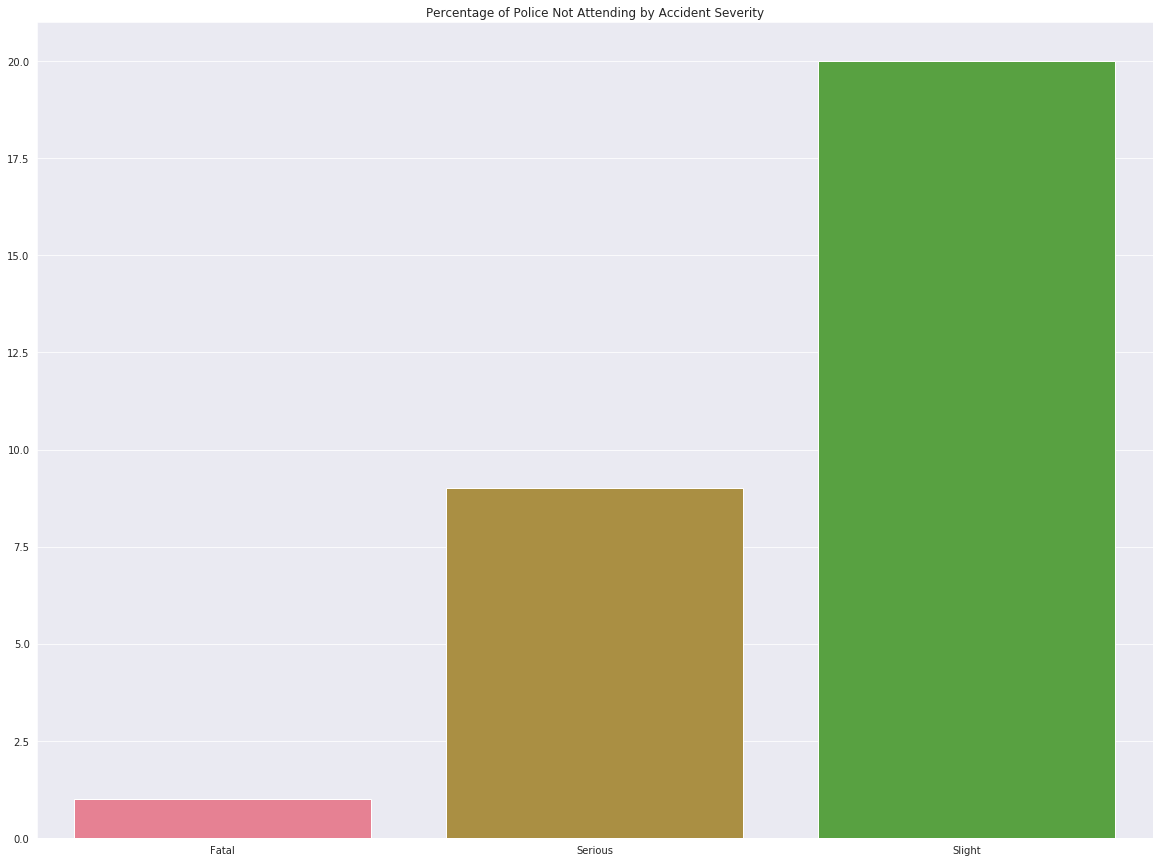

In [122]:
a=np.round((np.array(sever_by_attend.loc[
    sever_by_attend.Did_Police_Officer_Attend_Scene_of_Accident=='NO',['Accident_Index']])/
  (np.array(sever_by_attend.loc[
    sever_by_attend.Did_Police_Officer_Attend_Scene_of_Accident=='YES',['Accident_Index']])
 +np.array(sever_by_attend.loc[
     sever_by_attend.Did_Police_Officer_Attend_Scene_of_Accident=='NO',['Accident_Index']]))),2)*100

plt.figure(2, figsize=(20,15))
sns.barplot(x=sever_by_attend.Accident_Severity.unique(),y=a[:,0])
plt.title("Percentage of Police Not Attending by Accident Severity")

#### Number of Casualties 

/home/norayrm/.conda/envs/keras/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Histograms of Number of Casualties Attended vs Not Attended')

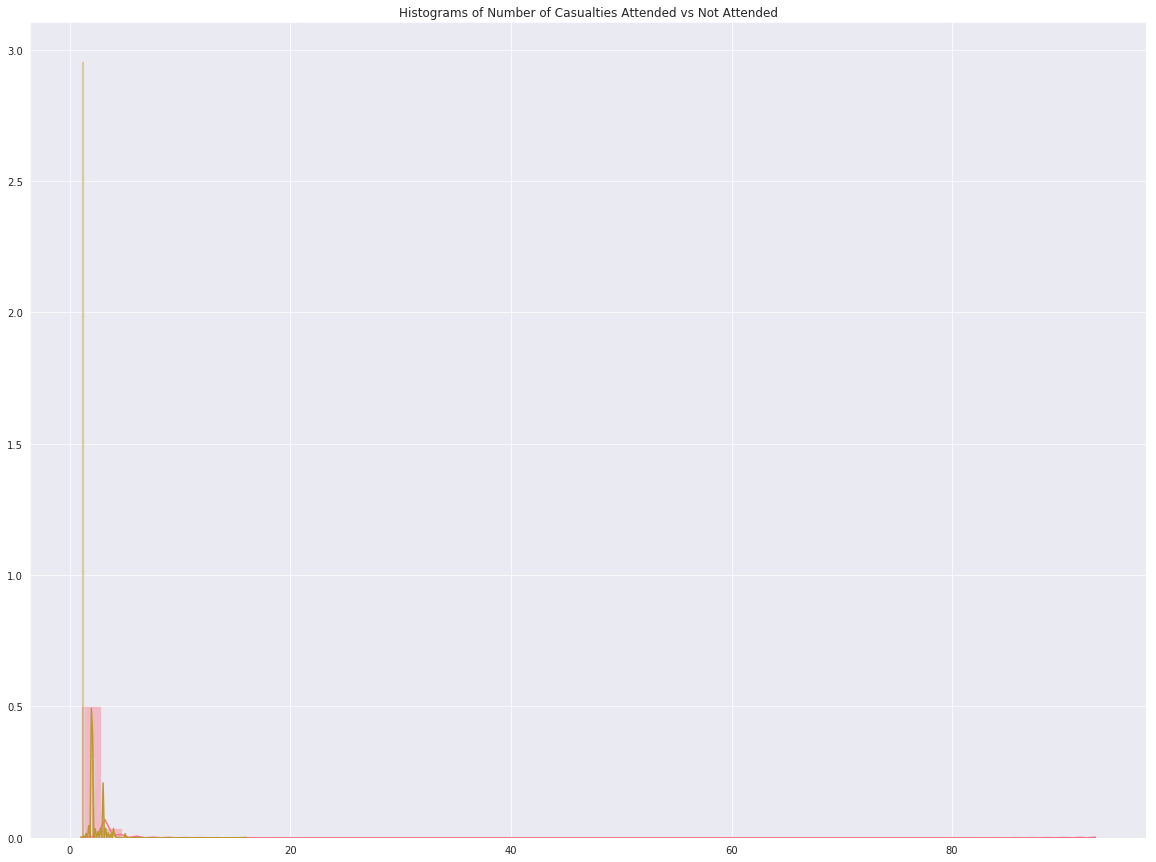

In [123]:
plt.figure(2, figsize=(20,15))
sns.distplot(df_acc.loc[df_acc.Did_Police_Officer_Attend_Scene_of_Accident == 1,
                        ['Number_of_Casualties']],bins=50,label="Attended")
sns.distplot(df_acc.loc[df_acc.Did_Police_Officer_Attend_Scene_of_Accident == 0,
                        ['Number_of_Casualties']],bins=50,label='Not Attended')
plt.title('Histograms of Number of Casualties Attended vs Not Attended')

Text(0.5, 1.0, 'Zoomed Histograms of Number of Casualties Attended vs Not Attended')

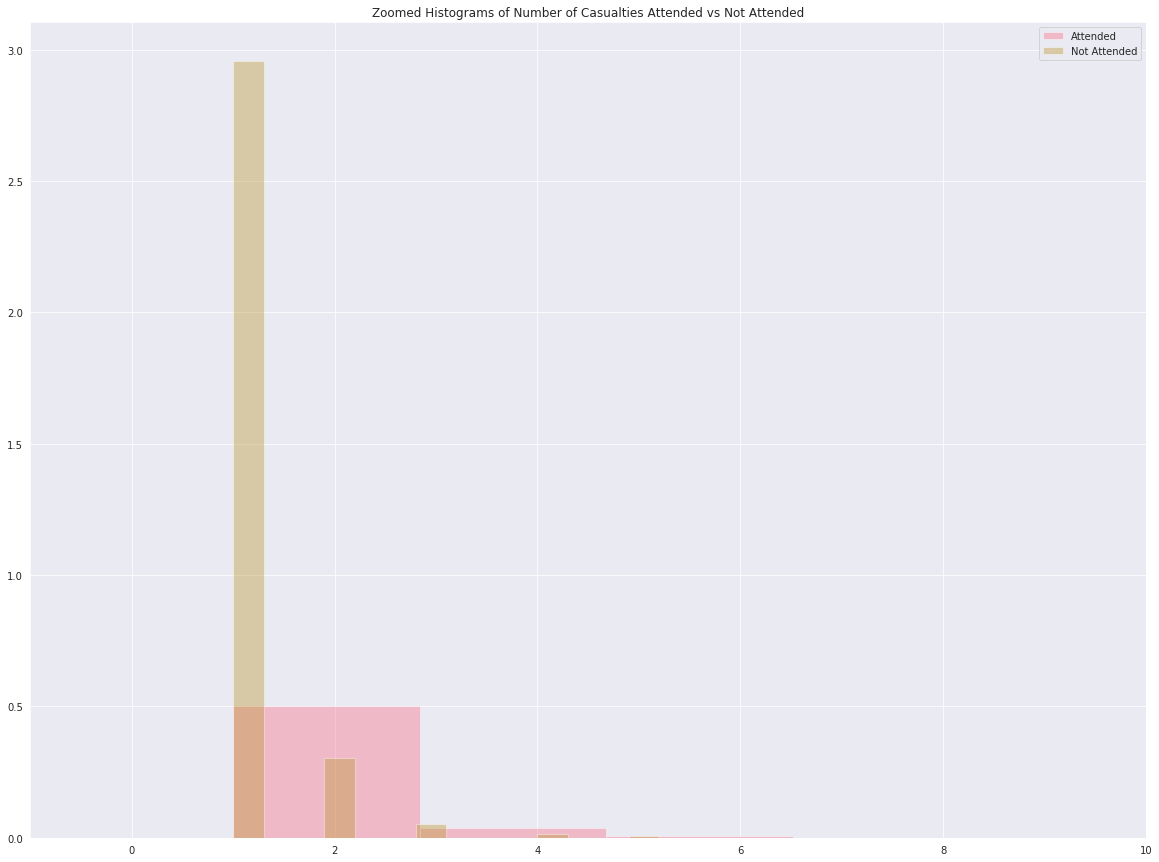

In [124]:
plt.figure(2, figsize=(20,15))
sns.distplot(df_acc.loc[df_acc.Did_Police_Officer_Attend_Scene_of_Accident == 1,
                        ['Number_of_Casualties']],norm_hist=True,bins=50,kde=False,label="Attended")
sns.distplot(df_acc.loc[df_acc.Did_Police_Officer_Attend_Scene_of_Accident == 0,
                        ['Number_of_Casualties']],norm_hist=True,bins=50,kde=False,label='Not Attended')
plt.xlim(-1, 10)
plt.legend()
plt.title('Zoomed Histograms of Number of Casualties Attended vs Not Attended')

#### Number of Vehicles

Text(0.5, 1.0, 'Histograms of Number of Vehicles Attended vs Not Attended')

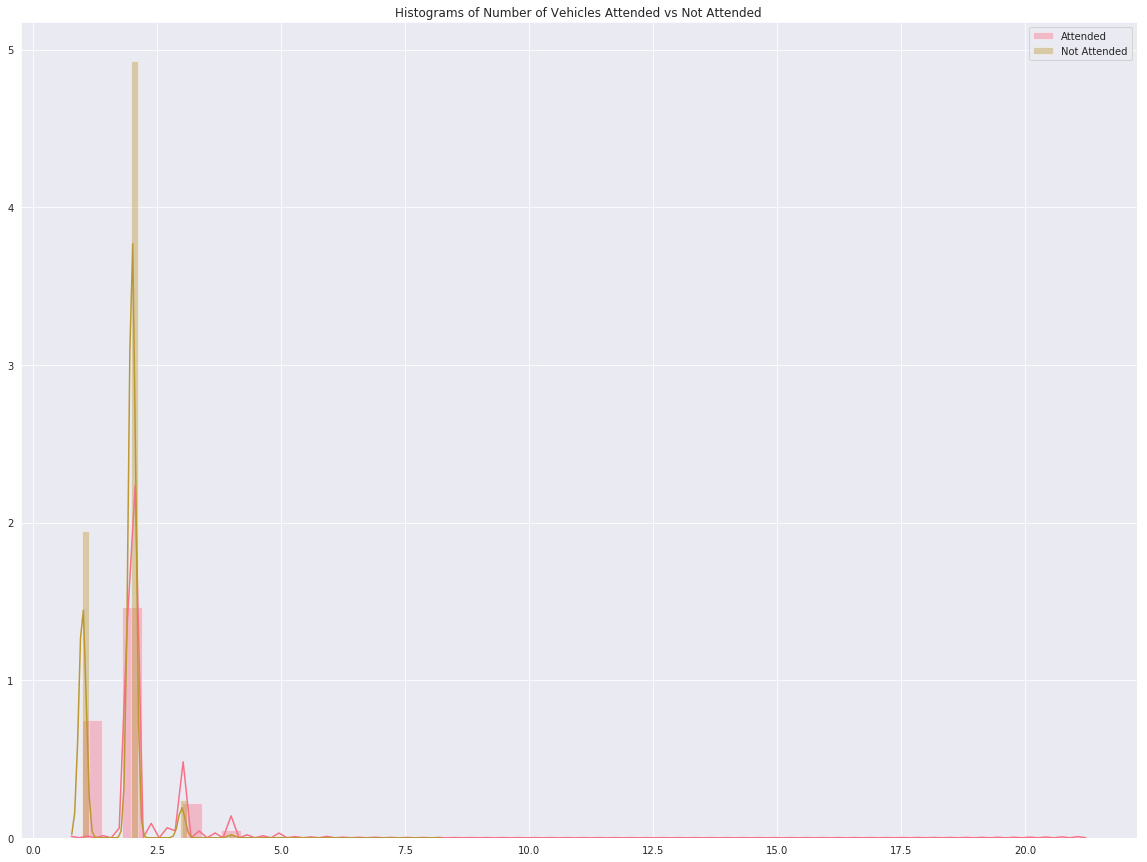

In [125]:
plt.figure(2, figsize=(20,15))
sns.distplot(df_acc.loc[df_acc.Did_Police_Officer_Attend_Scene_of_Accident == 1,
                        ['Number_of_Vehicles']],bins=50,label="Attended")
sns.distplot(df_acc.loc[df_acc.Did_Police_Officer_Attend_Scene_of_Accident == 0,
                        ['Number_of_Vehicles']],bins=50,label='Not Attended')
plt.legend()
plt.title('Histograms of Number of Vehicles Attended vs Not Attended')

Text(0.5, 1.0, 'Zoomed Histograms of Number of Vehicles Attended vs Not Attended')

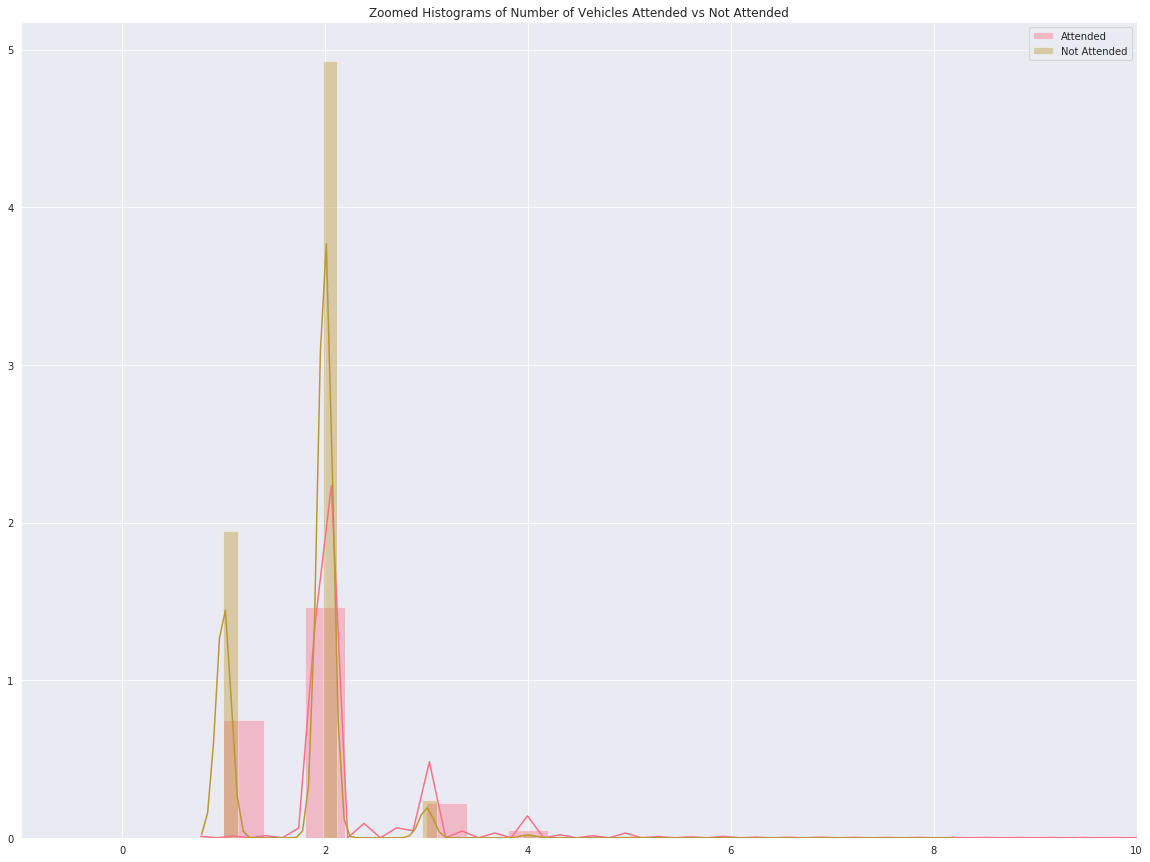

In [126]:
plt.figure(2, figsize=(20,15))
sns.distplot(df_acc.loc[df_acc.Did_Police_Officer_Attend_Scene_of_Accident == 1,
                        ['Number_of_Vehicles']],bins=50,label="Attended")
sns.distplot(df_acc.loc[df_acc.Did_Police_Officer_Attend_Scene_of_Accident == 0,
                        ['Number_of_Vehicles']],bins=50,label='Not Attended')
plt.xlim(-1, 10)
plt.legend()
plt.title('Zoomed Histograms of Number of Vehicles Attended vs Not Attended')

#### 1st_Road_Class

,1st_Road_Class,Did_Police_Officer_Attend_Scene_of_Accident,Accident_Index
0,A,NO,11024
1,A,YES,56804
2,A(M),NO,30
3,A(M),YES,354
4,B,NO,3254
5,B,YES,15319
6,C,NO,2380
7,C,YES,10589
8,Motorway,NO,389
9,Motorway,YES,4857


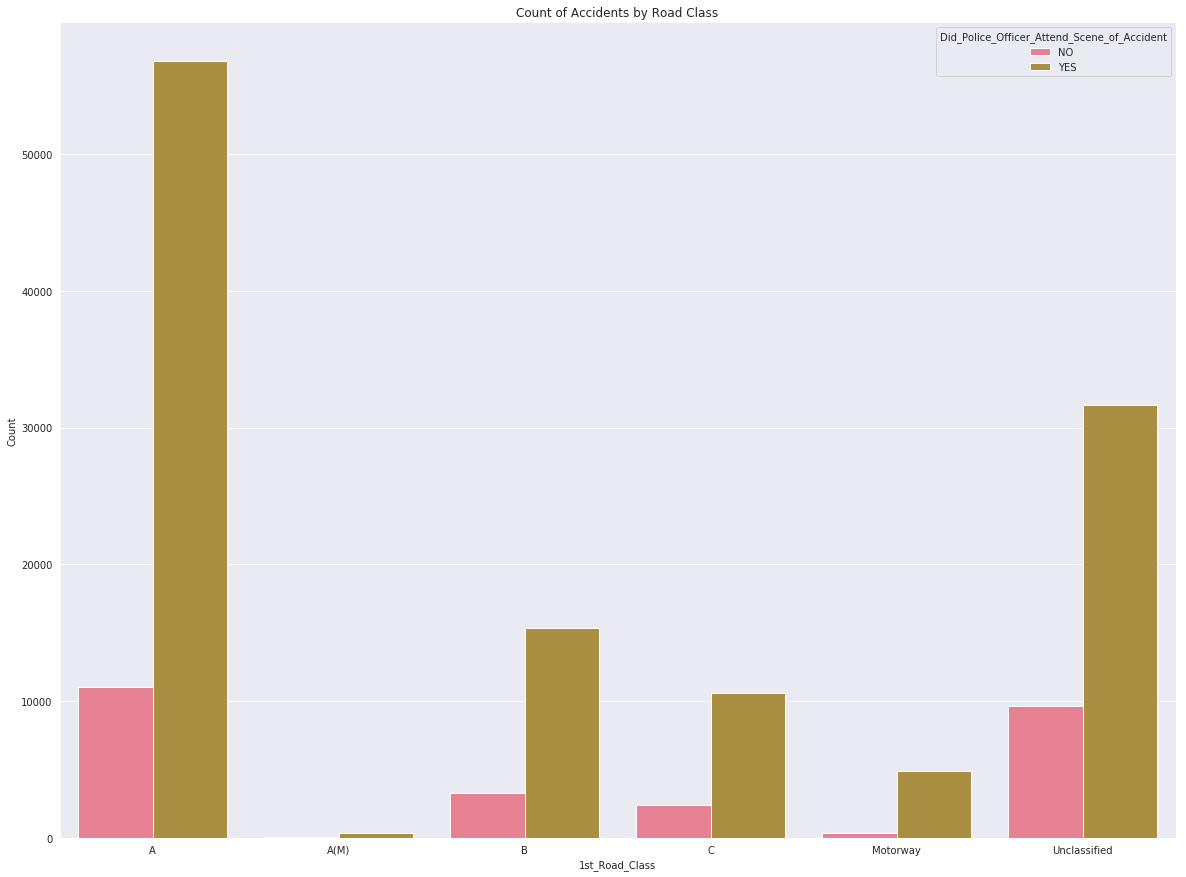

In [127]:
road_by_attend=df_acc.replace({'1st_Road_Class':
                               {1:'Motorway',2:'A(M)',3:'A',4:'B',5:'C',6:'Unclassified'},
              'Did_Police_Officer_Attend_Scene_of_Accident':{0:'NO',1:'YES'}})[
    ['1st_Road_Class','Did_Police_Officer_Attend_Scene_of_Accident','Accident_Index']].groupby(
      ['1st_Road_Class','Did_Police_Officer_Attend_Scene_of_Accident']).count().reset_index()

plt.figure(2, figsize=(20,15))
sns.barplot(x='1st_Road_Class', y='Accident_Index', 
            hue ='Did_Police_Officer_Attend_Scene_of_Accident',
            data=road_by_attend)
plt.ylabel("Count")
plt.title('Count of Accidents by Road Class')

road_by_attend

Text(0.5, 1.0, 'Percentage of Police Not Attending by Road Class')

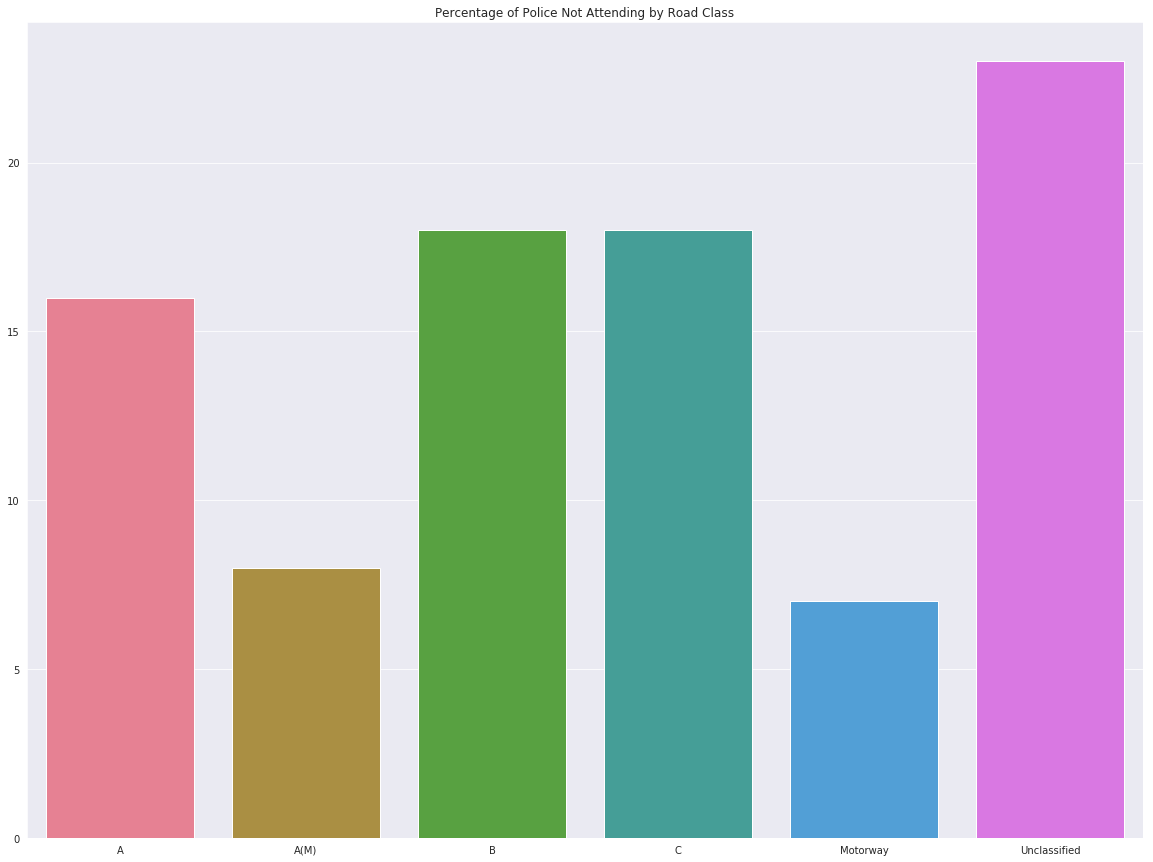

In [128]:
a=np.round((np.array(road_by_attend.loc[
    road_by_attend.Did_Police_Officer_Attend_Scene_of_Accident=='NO',['Accident_Index']])/
  (np.array(road_by_attend.loc[
    road_by_attend.Did_Police_Officer_Attend_Scene_of_Accident=='YES',['Accident_Index']])
 +np.array(road_by_attend.loc[
     road_by_attend.Did_Police_Officer_Attend_Scene_of_Accident=='NO',['Accident_Index']]))),2)*100

plt.figure(2, figsize=(20,15))
sns.barplot(x=road_by_attend['1st_Road_Class'].unique(),y=a[:,0])
plt.title("Percentage of Police Not Attending by Road Class")

#### Road_Type

,Road_Type,Did_Police_Officer_Attend_Scene_of_Accident,Accident_Index
0,Dual carriageway,NO,2664
1,Dual carriageway,YES,18159
2,One way street,NO,790
3,One way street,YES,2145
4,Roundabout,NO,2628
5,Roundabout,YES,7701
6,Single carriageway,NO,20187
7,Single carriageway,YES,90000
8,Slip road,NO,256
9,Slip road,YES,1286


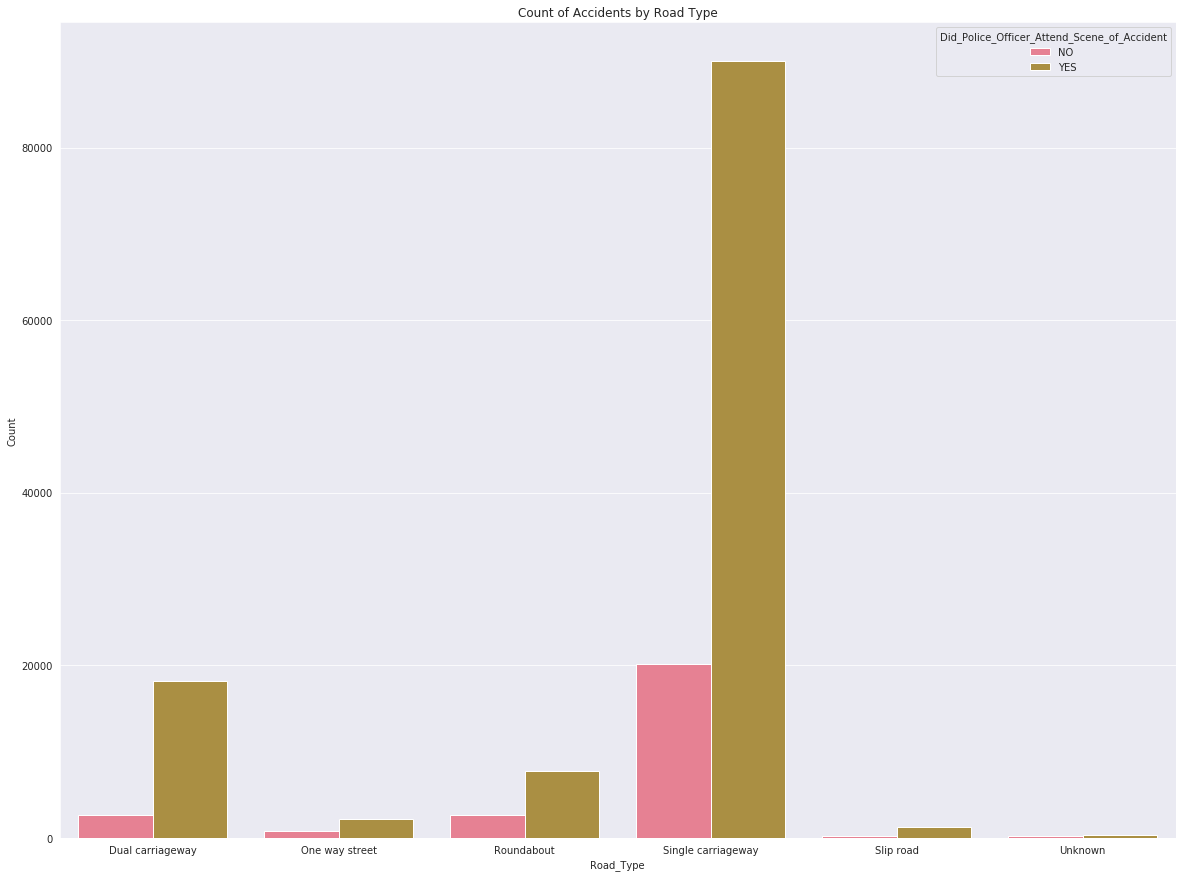

In [129]:
roadtype_by_attend=df_acc.replace({'Road_Type':
                               {1:'Roundabout',2:'One way street',3:'Dual carriageway',
                                6:'Single carriageway',7:'Slip road',9:'Unknown',
                                12:'One way street/Slip road'},
              'Did_Police_Officer_Attend_Scene_of_Accident':{0:'NO',1:'YES'}})[
    ['Road_Type','Did_Police_Officer_Attend_Scene_of_Accident','Accident_Index']].groupby(
      ['Road_Type','Did_Police_Officer_Attend_Scene_of_Accident']).count().reset_index()

plt.figure(2, figsize=(20,15))
sns.barplot(x='Road_Type', y='Accident_Index', 
            hue ='Did_Police_Officer_Attend_Scene_of_Accident',
            data=roadtype_by_attend)
plt.ylabel("Count")
plt.title('Count of Accidents by Road Type')
roadtype_by_attend

Text(0.5, 1.0, 'Percentage of Police Not Attending by Road Type')

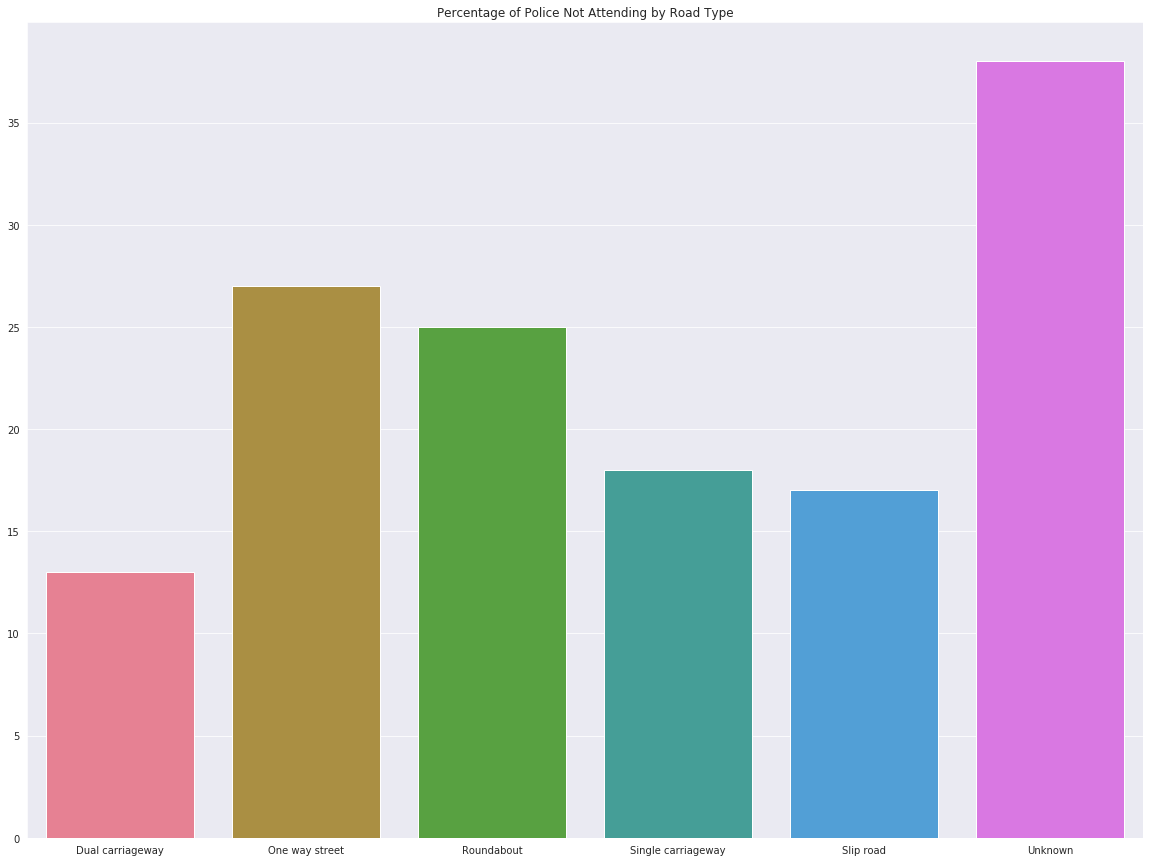

In [130]:
a=np.round((np.array(roadtype_by_attend.loc[
    roadtype_by_attend.Did_Police_Officer_Attend_Scene_of_Accident=='NO',['Accident_Index']])/
  (np.array(roadtype_by_attend.loc[
    roadtype_by_attend.Did_Police_Officer_Attend_Scene_of_Accident=='YES',['Accident_Index']])
 +np.array(roadtype_by_attend.loc[
     roadtype_by_attend.Did_Police_Officer_Attend_Scene_of_Accident=='NO',['Accident_Index']]))),2)*100

plt.figure(2, figsize=(20,15))
sns.barplot(x=roadtype_by_attend['Road_Type'].unique(),y=a[:,0])
plt.title("Percentage of Police Not Attending by Road Type")

#### Speed Limit

Text(0.5, 1.0, 'Histograms of Number of Accidents for Each Speed Limit Attended vs Not Attended')

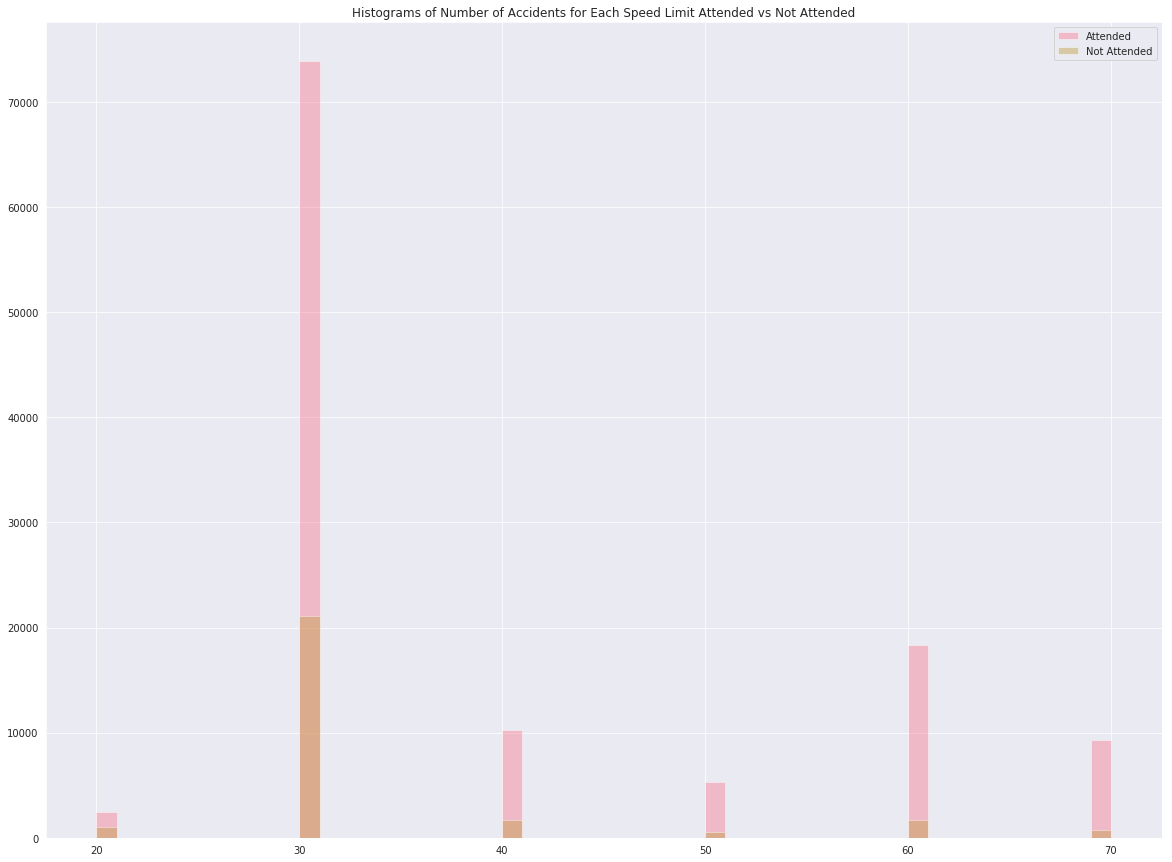

In [131]:
plt.figure(2, figsize=(20,15))
sns.distplot(df_acc.loc[df_acc.Did_Police_Officer_Attend_Scene_of_Accident == 1,
                        ['Speed_limit']],bins=50,kde=False,label="Attended")
sns.distplot(df_acc.loc[df_acc.Did_Police_Officer_Attend_Scene_of_Accident == 0,
                        ['Speed_limit']],bins=50,kde=False,label='Not Attended')
# plt.xlim(-1, 10)

plt.legend()
plt.title('Histograms of Number of Accidents for Each Speed Limit Attended vs Not Attended')

In [132]:
df_acc.Speed_limit.unique()

array([30, 40, 20, 50, 70, 60])

,Speed_limit,Did_Police_Officer_Attend_Scene_of_Accident,Accident_Index
0,20,NO,980
1,20,YES,2438
2,30,NO,21110
3,30,YES,73887
4,40,NO,1727
5,40,YES,10290
6,50,NO,511
7,50,YES,5286
8,60,NO,1662
9,60,YES,18354


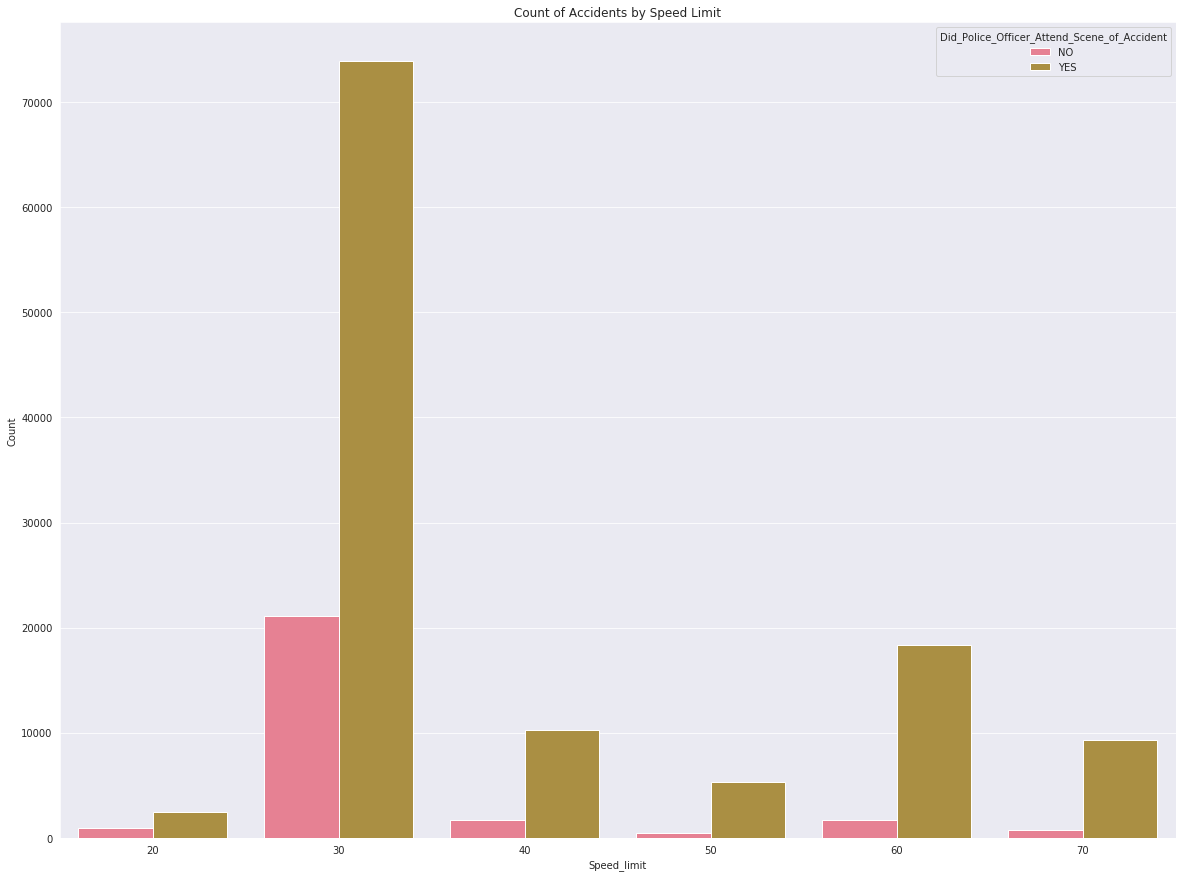

In [133]:
roadtype_by_limit=df_acc.replace({'Did_Police_Officer_Attend_Scene_of_Accident':{0:'NO',1:'YES'}})[
    ['Speed_limit','Did_Police_Officer_Attend_Scene_of_Accident','Accident_Index']].groupby(
      ['Speed_limit','Did_Police_Officer_Attend_Scene_of_Accident']).count().reset_index()

plt.figure(2, figsize=(20,15))
sns.barplot(x='Speed_limit', y='Accident_Index', 
            hue ='Did_Police_Officer_Attend_Scene_of_Accident',
            data=roadtype_by_limit)
plt.ylabel("Count")
plt.title('Count of Accidents by Speed Limit')
roadtype_by_limit

Text(0.5, 1.0, 'Percentage of Police Not Attending by Speed Limit')

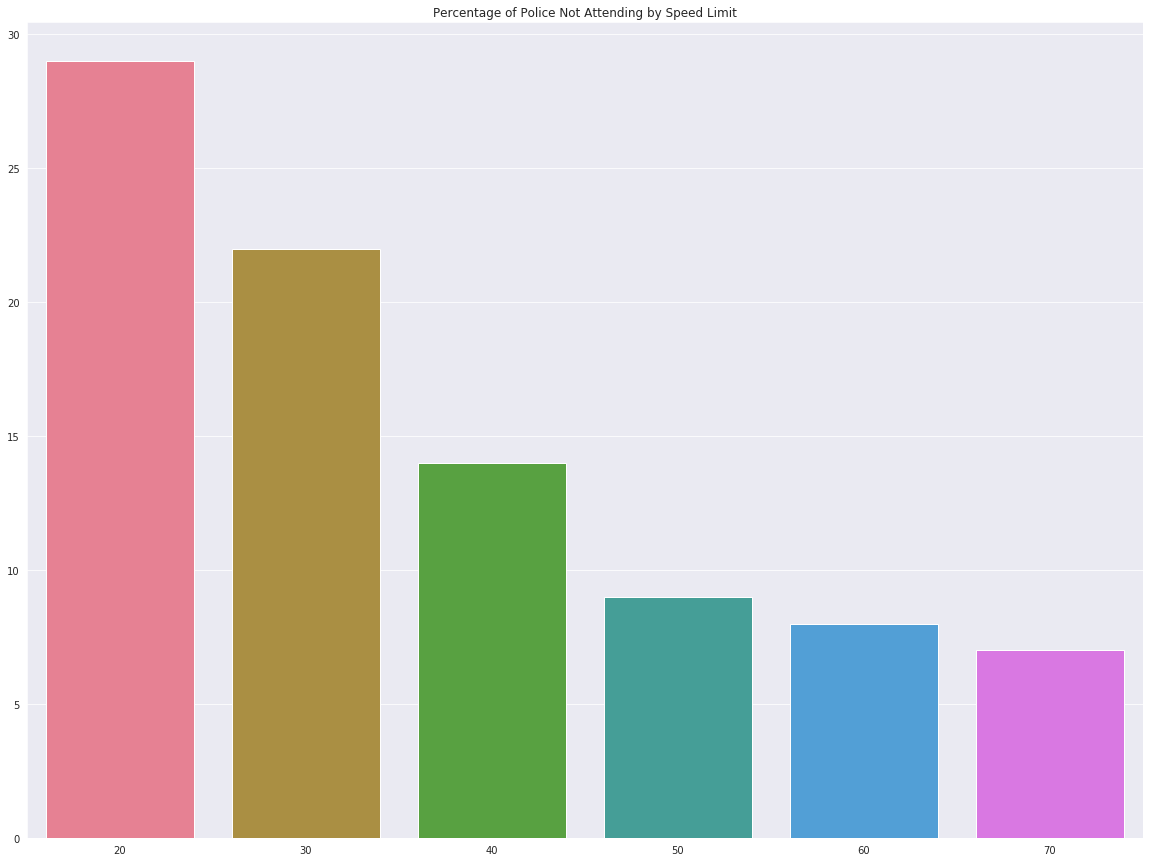

In [134]:
a=np.round((np.array(roadtype_by_limit.loc[
    roadtype_by_limit.Did_Police_Officer_Attend_Scene_of_Accident=='NO',['Accident_Index']])/
  (np.array(roadtype_by_limit.loc[
    roadtype_by_limit.Did_Police_Officer_Attend_Scene_of_Accident=='YES',['Accident_Index']])
 +np.array(roadtype_by_limit.loc[
     roadtype_by_limit.Did_Police_Officer_Attend_Scene_of_Accident=='NO',['Accident_Index']]))),2)*100

plt.figure(2, figsize=(20,15))
sns.barplot(x=roadtype_by_limit['Speed_limit'].unique(),y=a[:,0])
plt.title("Percentage of Police Not Attending by Speed Limit")

#### Junction Detail

,Junction_Detail,Did_Police_Officer_Attend_Scene_of_Accident,Accident_Index
0,Crossroads,NO,2320
1,Crossroads,YES,12266
2,Mini-roundabout,NO,459
3,Mini-roundabout,YES,1497
4,More than 4 arms (not roundabout),NO,187
5,More than 4 arms (not roundabout),YES,830
6,Not at junction or within 20 metres,NO,9199
7,Not at junction or within 20 metres,YES,47211
8,Other junction,NO,547
9,Other junction,YES,2578


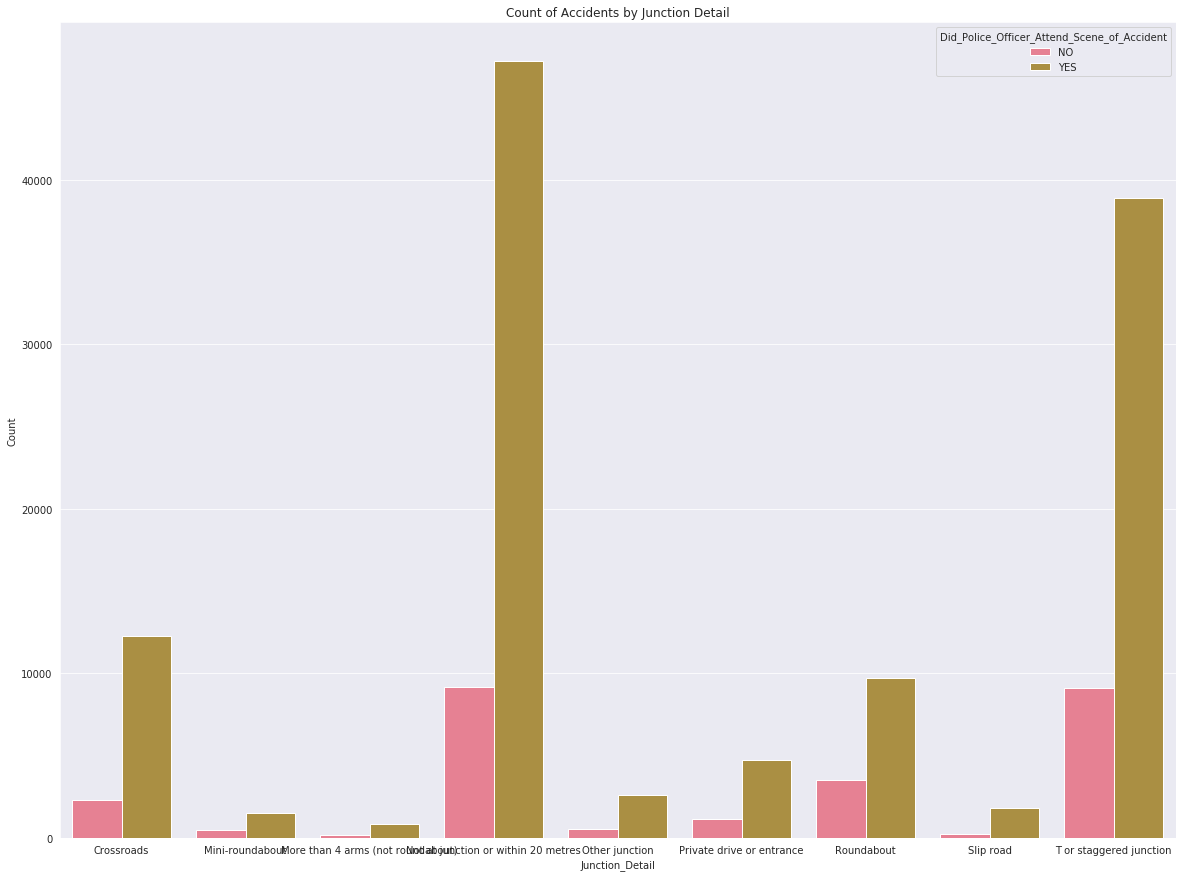

In [135]:
roadtype_by_jd=df_acc.replace({'Junction_Detail':
                               {0:'Not at junction or within 20 metres',
                                1:'Roundabout',
                                2:'Mini-roundabout',
                                3:'T or staggered junction',
                                5:'Slip road',
                                6:'Crossroads',
                                7:'More than 4 arms (not roundabout)',
                                8:'Private drive or entrance',
                                9:'Other junction'},
              'Did_Police_Officer_Attend_Scene_of_Accident':{0:'NO',1:'YES'}})[
    ['Junction_Detail','Did_Police_Officer_Attend_Scene_of_Accident','Accident_Index']].groupby(
      ['Junction_Detail','Did_Police_Officer_Attend_Scene_of_Accident']).count().reset_index()

plt.figure(2, figsize=(20,15))
sns.barplot(x='Junction_Detail', y='Accident_Index', 
            hue ='Did_Police_Officer_Attend_Scene_of_Accident',
            data=roadtype_by_jd)
plt.ylabel("Count")
plt.title('Count of Accidents by Junction Detail')
roadtype_by_jd

Text(0.5, 1.0, 'Percentage of Police Not Attending by Junction Detail')

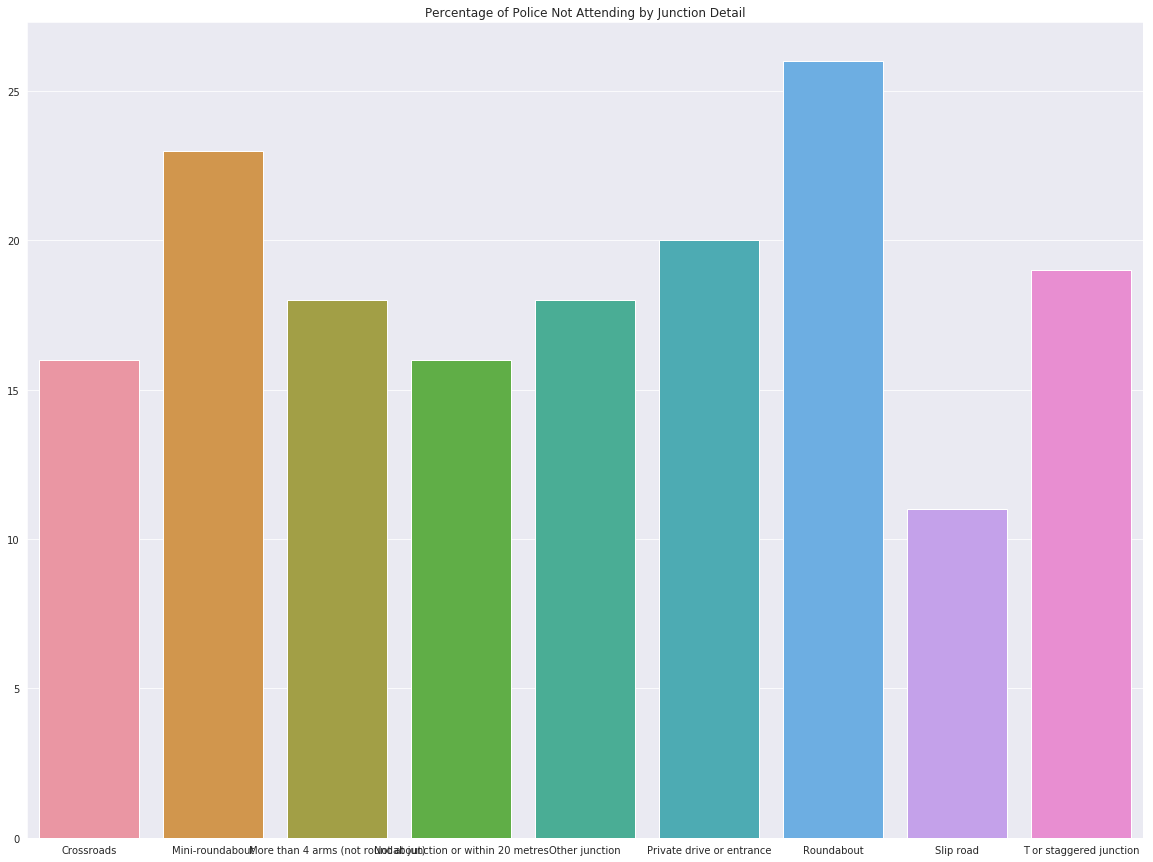

In [136]:
a=np.round((np.array(roadtype_by_jd.loc[
    roadtype_by_jd.Did_Police_Officer_Attend_Scene_of_Accident=='NO',['Accident_Index']])/
  (np.array(roadtype_by_jd.loc[
    roadtype_by_jd.Did_Police_Officer_Attend_Scene_of_Accident=='YES',['Accident_Index']])
 +np.array(roadtype_by_jd.loc[
     roadtype_by_jd.Did_Police_Officer_Attend_Scene_of_Accident=='NO',['Accident_Index']]))),2)*100

plt.figure(2, figsize=(20,15))
sns.barplot(x=roadtype_by_jd['Junction_Detail'].unique(),y=a[:,0])
plt.title("Percentage of Police Not Attending by Junction Detail")

#### Junction Control

,Junction_Control,Did_Police_Officer_Attend_Scene_of_Accident,Accident_Index
0,Authorised person,NO,41
1,Authorised person,YES,159
2,Auto traffic signal,NO,3130
3,Auto traffic signal,YES,12143
4,Give way or uncontrolled,NO,14210
5,Give way or uncontrolled,YES,59529
6,Stop sign,NO,130
7,Stop sign,YES,513


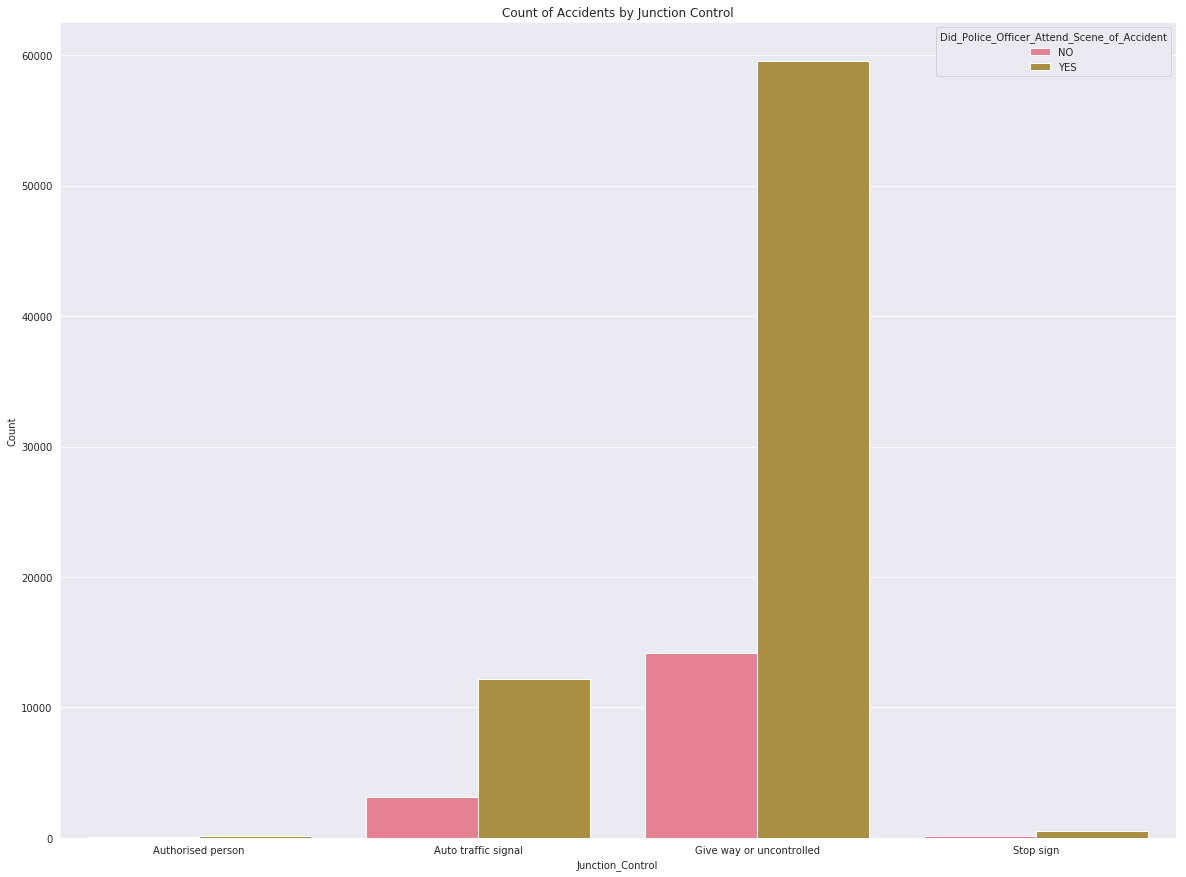

In [137]:
roadtype_by_jc=df_acc.replace({'Junction_Control':
                               {0:'Not at junction or within 20 metres',
                                1:'Authorised person',
                                2:'Auto traffic signal',
                                3:'Stop sign',
                                4:'Give way or uncontrolled',
                                -1:'Data missing or out of range'},
              'Did_Police_Officer_Attend_Scene_of_Accident':{0:'NO',1:'YES'}})[
    ['Junction_Control','Did_Police_Officer_Attend_Scene_of_Accident','Accident_Index']].groupby(
      ['Junction_Control','Did_Police_Officer_Attend_Scene_of_Accident']).count().reset_index()

plt.figure(2, figsize=(20,15))
sns.barplot(x='Junction_Control', y='Accident_Index', 
            hue ='Did_Police_Officer_Attend_Scene_of_Accident',
            data=roadtype_by_jc)
plt.ylabel("Count")
plt.title('Count of Accidents by Junction Control')
roadtype_by_jc

Text(0.5, 1.0, 'Percentage of Police Not Attending by Junction Control')

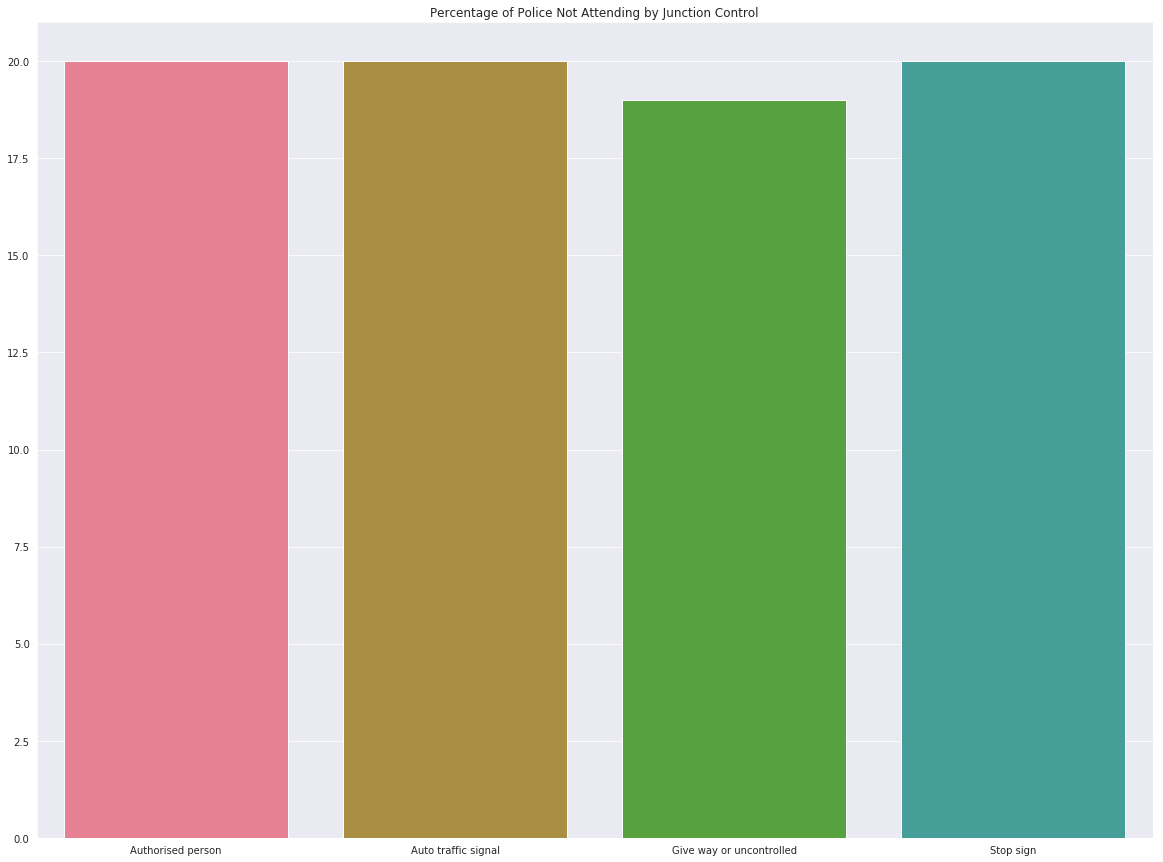

In [138]:
a=np.round((np.array(roadtype_by_jc.loc[
    roadtype_by_jc.Did_Police_Officer_Attend_Scene_of_Accident=='NO',['Accident_Index']])/
  (np.array(roadtype_by_jc.loc[
    roadtype_by_jc.Did_Police_Officer_Attend_Scene_of_Accident=='YES',['Accident_Index']])
 +np.array(roadtype_by_jc.loc[
     roadtype_by_jc.Did_Police_Officer_Attend_Scene_of_Accident=='NO',['Accident_Index']]))),2)*100

plt.figure(2, figsize=(20,15))
sns.barplot(x=roadtype_by_jc['Junction_Control'].unique(),y=a[:,0])
plt.title("Percentage of Police Not Attending by Junction Control")

#### Light Conditions

,Light_Conditions,Did_Police_Officer_Attend_Scene_of_Accident,Accident_Index
0,Darkness - lighting unknown,NO,659
1,Darkness - lighting unknown,YES,1072
2,Darkness - lights lit,NO,4668
3,Darkness - lights lit,YES,23781
4,Darkness - lights unlit,NO,121
5,Darkness - lights unlit,YES,751
6,Darkness - no lighting,NO,419
7,Darkness - no lighting,YES,6780
8,Daylight,NO,20848
9,Daylight,YES,87223


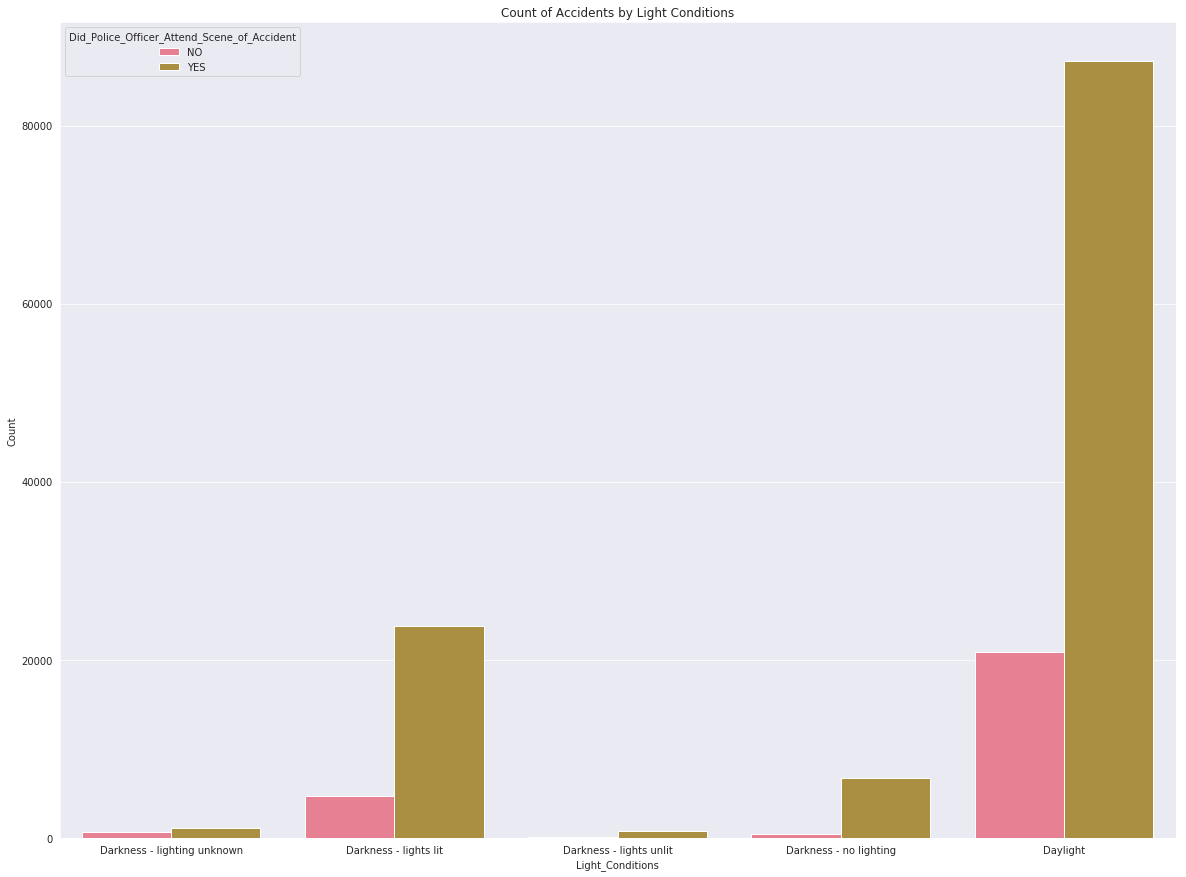

In [139]:
roadtype_by_lc=df_acc.replace({'Light_Conditions':
                               {1:'Daylight',
                                4:'Darkness - lights lit',
                                5:'Darkness - lights unlit',
                                6:'Darkness - no lighting',
                                7:'Darkness - lighting unknown'},
              'Did_Police_Officer_Attend_Scene_of_Accident':{0:'NO',1:'YES'}})[
    ['Light_Conditions','Did_Police_Officer_Attend_Scene_of_Accident','Accident_Index']].groupby(
      ['Light_Conditions','Did_Police_Officer_Attend_Scene_of_Accident']).count().reset_index()

plt.figure(2, figsize=(20,15))
sns.barplot(x='Light_Conditions', y='Accident_Index', 
            hue ='Did_Police_Officer_Attend_Scene_of_Accident',
            data=roadtype_by_lc)
plt.ylabel("Count")
plt.title('Count of Accidents by Light Conditions')
roadtype_by_lc

Text(0.5, 1.0, 'Percentage of Police Not Attending by Light Conditions')

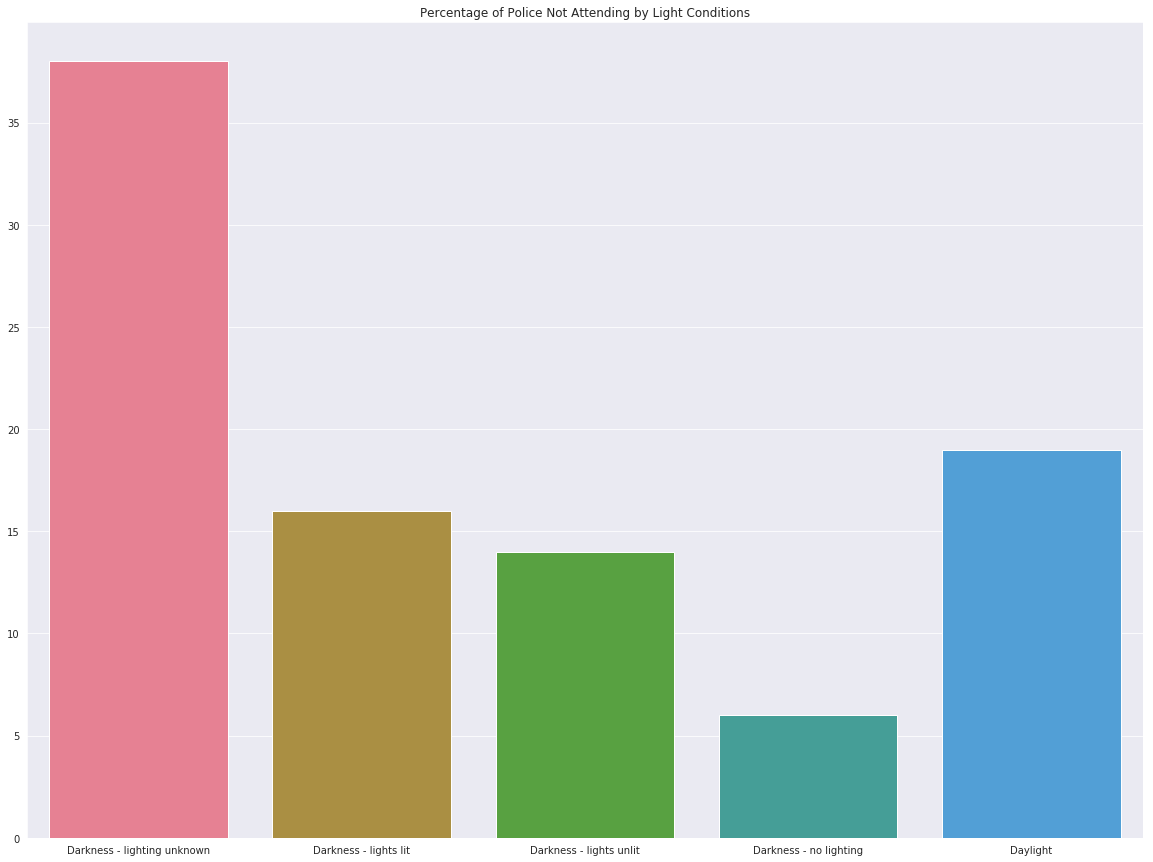

In [140]:
a=np.round((np.array(roadtype_by_lc.loc[
    roadtype_by_lc.Did_Police_Officer_Attend_Scene_of_Accident=='NO',['Accident_Index']])/
  (np.array(roadtype_by_lc.loc[
    roadtype_by_lc.Did_Police_Officer_Attend_Scene_of_Accident=='YES',['Accident_Index']])
 +np.array(roadtype_by_lc.loc[
     roadtype_by_lc.Did_Police_Officer_Attend_Scene_of_Accident=='NO',['Accident_Index']]))),2)*100

plt.figure(2, figsize=(20,15))
sns.barplot(x=roadtype_by_lc['Light_Conditions'].unique(),y=a[:,0])
plt.title("Percentage of Police Not Attending by Light Conditions")

#### Weather Conditions

,Weather_Conditions,Did_Police_Officer_Attend_Scene_of_Accident,Accident_Index
0,Fine + high winds,NO,215
1,Fine + high winds,YES,1360
2,Fine no high winds,NO,21690
3,Fine no high winds,YES,97189
4,Fog or mist,NO,86
5,Fog or mist,YES,667
6,Other,NO,427
7,Other,YES,1905
8,Raining + high winds,NO,295
9,Raining + high winds,YES,2038


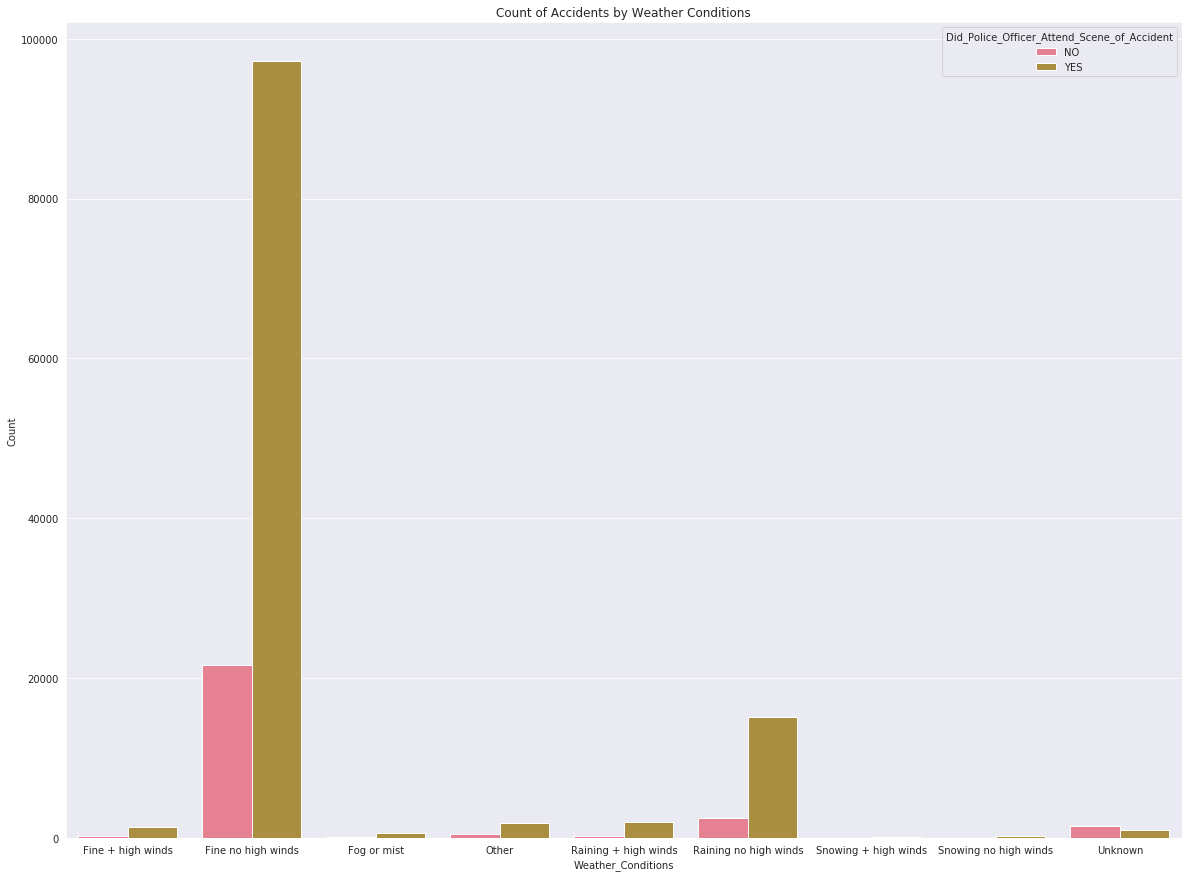

In [141]:
roadtype_by_wc=df_acc.replace({'Weather_Conditions':
                               {1:'Fine no high winds',
                                2:'Raining no high winds',
                                3:'Snowing no high winds',
                                4:'Fine + high winds',
                                5:'Raining + high winds',
                                6:'Snowing + high winds',
                                7:'Fog or mist',
                                8:'Other',
                                9:'Unknown'},
              'Did_Police_Officer_Attend_Scene_of_Accident':{0:'NO',1:'YES'}})[
    ['Weather_Conditions','Did_Police_Officer_Attend_Scene_of_Accident','Accident_Index']].groupby(
      ['Weather_Conditions','Did_Police_Officer_Attend_Scene_of_Accident']).count().reset_index()

plt.figure(2, figsize=(20,15))
sns.barplot(x='Weather_Conditions', y='Accident_Index', 
            hue ='Did_Police_Officer_Attend_Scene_of_Accident',
            data=roadtype_by_wc)
plt.ylabel("Count")
plt.title('Count of Accidents by Weather Conditions')
roadtype_by_wc

Text(0.5, 1.0, 'Percentage of Police Not Attending by Weather Conditions')

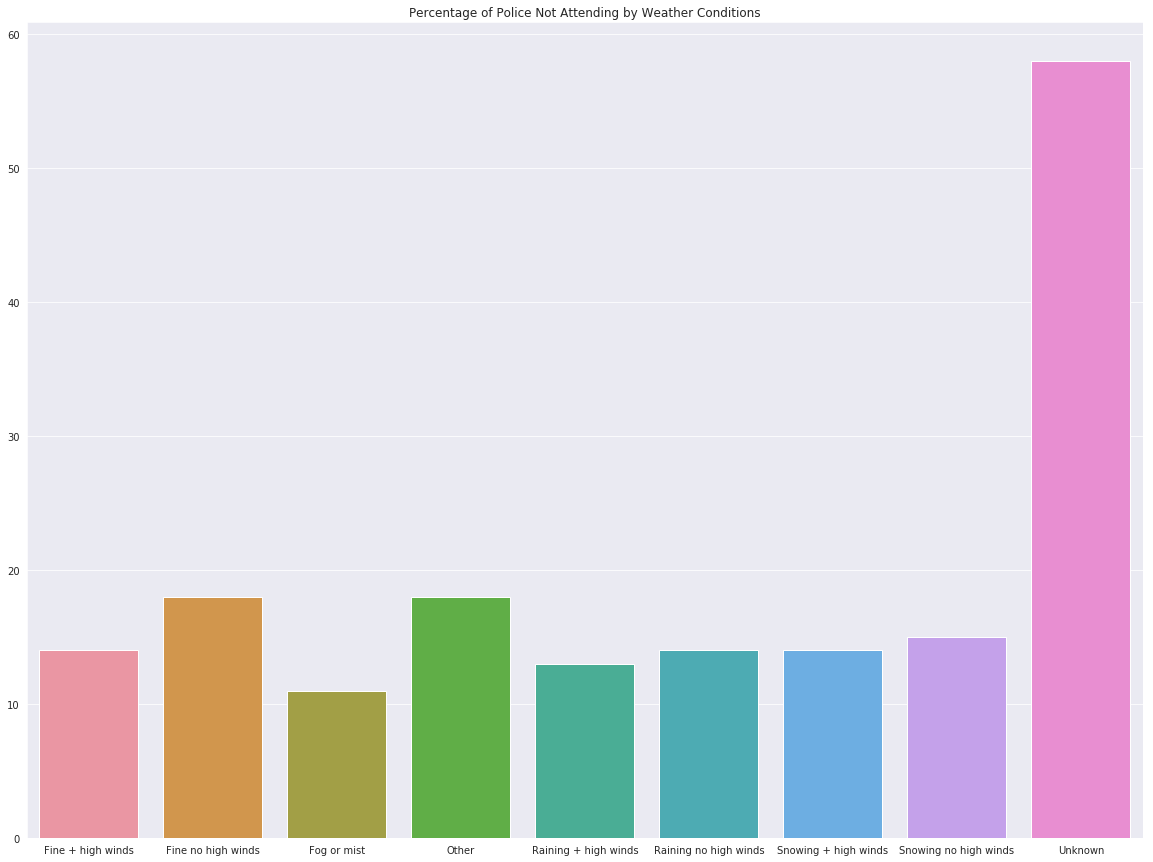

In [142]:
a=np.round((np.array(roadtype_by_wc.loc[
    roadtype_by_wc.Did_Police_Officer_Attend_Scene_of_Accident=='NO',['Accident_Index']])/
  (np.array(roadtype_by_wc.loc[
    roadtype_by_wc.Did_Police_Officer_Attend_Scene_of_Accident=='YES',['Accident_Index']])
 +np.array(roadtype_by_wc.loc[
     roadtype_by_wc.Did_Police_Officer_Attend_Scene_of_Accident=='NO',['Accident_Index']]))),2)*100

plt.figure(2, figsize=(20,15))
sns.barplot(x=roadtype_by_wc['Weather_Conditions'].unique(),y=a[:,0])
plt.title("Percentage of Police Not Attending by Weather Conditions")

#### Road Surface Conditions

,Road_Surface_Conditions,Did_Police_Officer_Attend_Scene_of_Accident,Accident_Index
0,Dry,NO,20578
1,Dry,YES,81441
2,Flood over 3cm. deep,NO,17
3,Flood over 3cm. deep,YES,245
4,Frost or ice,NO,148
5,Frost or ice,YES,1544
6,Snow,NO,36
7,Snow,YES,170
8,Wet or damp,NO,5758
9,Wet or damp,YES,36163


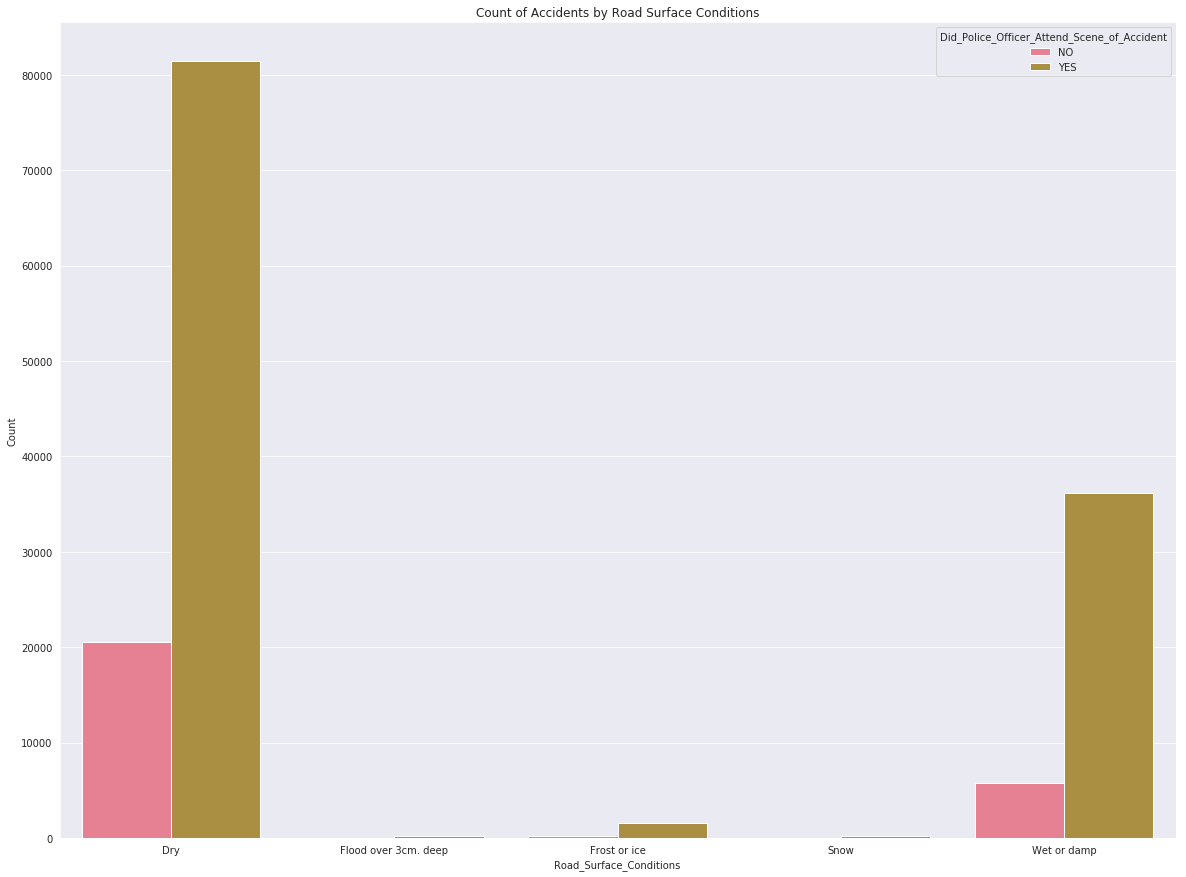

In [143]:
roadtype_by_rsc=df_acc.replace({'Road_Surface_Conditions':
                               {1:'Dry',
                                2:'Wet or damp',
                                3:'Snow',
                                4:'Frost or ice',
                                5:'Flood over 3cm. deep',
                                6:'Oil or diesel',
                                7:'Mud'},
              'Did_Police_Officer_Attend_Scene_of_Accident':{0:'NO',1:'YES'}})[
    ['Road_Surface_Conditions','Did_Police_Officer_Attend_Scene_of_Accident','Accident_Index']].groupby(
      ['Road_Surface_Conditions','Did_Police_Officer_Attend_Scene_of_Accident']).count().reset_index()

plt.figure(2, figsize=(20,15))
sns.barplot(x='Road_Surface_Conditions', y='Accident_Index', 
            hue ='Did_Police_Officer_Attend_Scene_of_Accident',
            data=roadtype_by_rsc)
plt.ylabel("Count")
plt.title('Count of Accidents by Road Surface Conditions')
roadtype_by_rsc

Text(0.5, 1.0, 'Percentage of Police Not Attending by Road Surface Conditions')

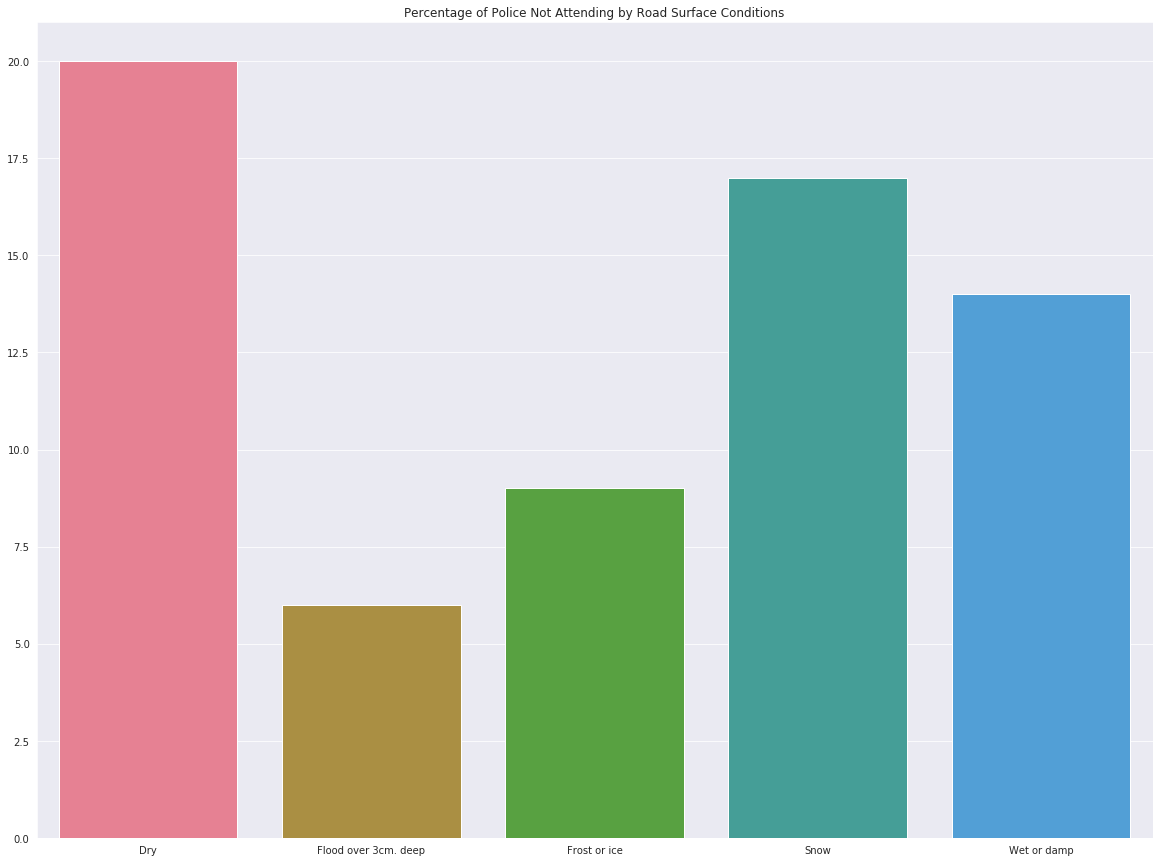

In [144]:
a=np.round((np.array(roadtype_by_rsc.loc[
    roadtype_by_rsc.Did_Police_Officer_Attend_Scene_of_Accident=='NO',['Accident_Index']])/
  (np.array(roadtype_by_rsc.loc[
    roadtype_by_rsc.Did_Police_Officer_Attend_Scene_of_Accident=='YES',['Accident_Index']])
 +np.array(roadtype_by_rsc.loc[
     roadtype_by_rsc.Did_Police_Officer_Attend_Scene_of_Accident=='NO',['Accident_Index']]))),2)*100

plt.figure(2, figsize=(20,15))
sns.barplot(x=roadtype_by_rsc['Road_Surface_Conditions'].unique(),y=a[:,0])
plt.title("Percentage of Police Not Attending by Road Surface Conditions")

#### Time

Text(0.5, 1.0, 'Accidents per Month')

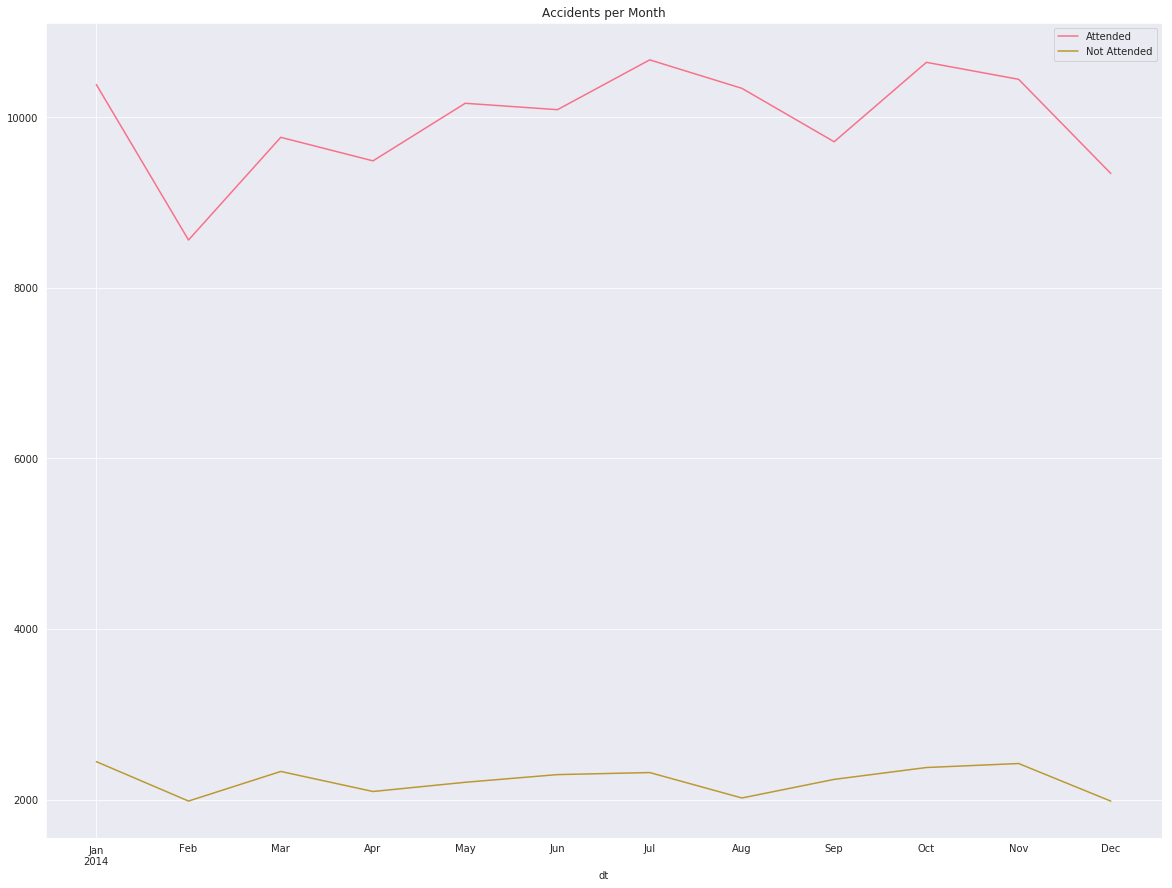

In [145]:
plt.figure(2, figsize=(20,15))
# df_acc.set_index('dt').resample('M').size().plot(label='Accidents per Month')
df_acc[df_acc.Did_Police_Officer_Attend_Scene_of_Accident==1
      ].set_index('dt').resample('M').size().plot(label='Attended')
df_acc[df_acc.Did_Police_Officer_Attend_Scene_of_Accident==0
      ].set_index('dt').resample('M').size().plot(label='Not Attended')
# sns.lineplot(x=df_acc_res_m.index,y= label='Accidents per Month'
#                             ,hue ='Did_Police_Officer_Attend_Scene_of_Accident')
plt.legend()
plt.title('Accidents per Month')
# df_acc_res_m

Text(0.5, 1.0, 'Accidents per Day')

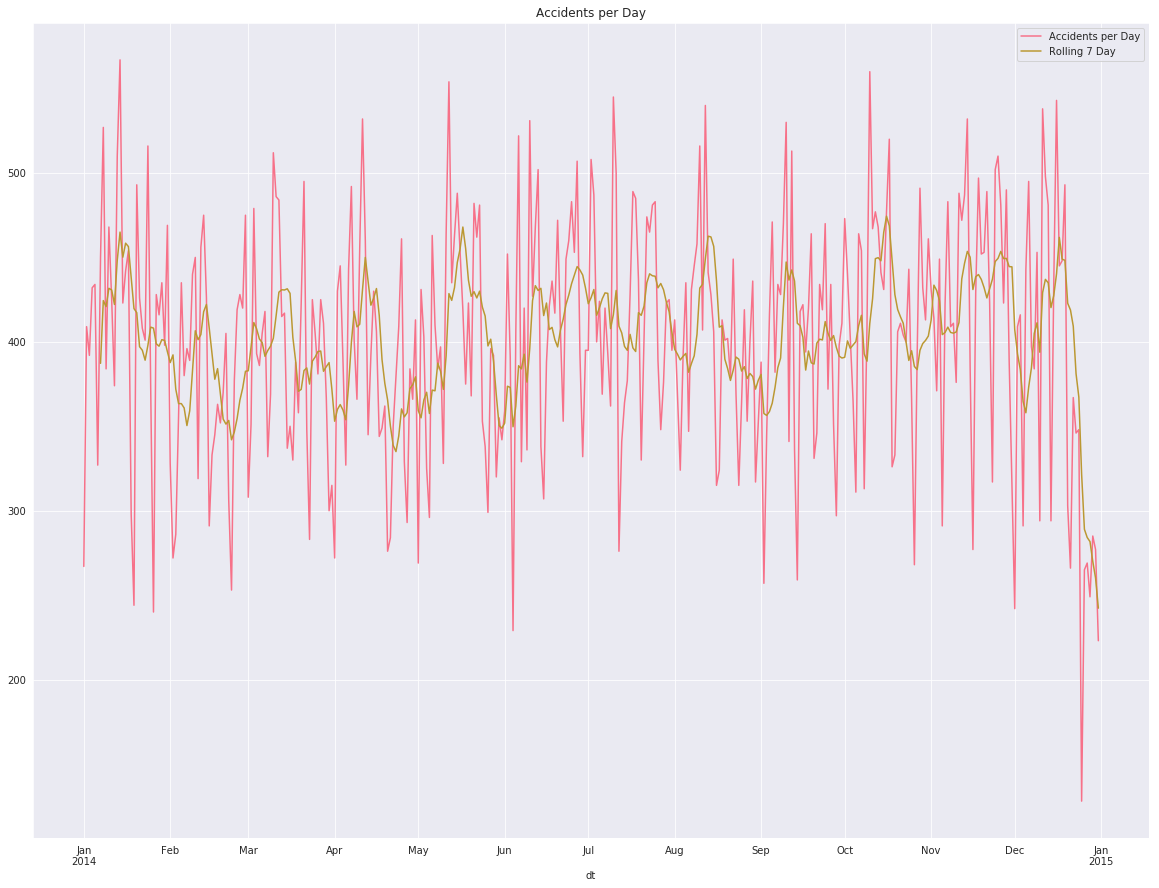

In [146]:
plt.figure(2, figsize=(20,15))
df_acc.set_index('dt').resample('D').size().plot(label='Accidents per Day')
df_acc.set_index('dt').resample('D').size().rolling(window=7).mean()\
                           .plot(label='Rolling 7 Day')
plt.legend()
plt.title('Accidents per Day')

### Checking Variable Relations

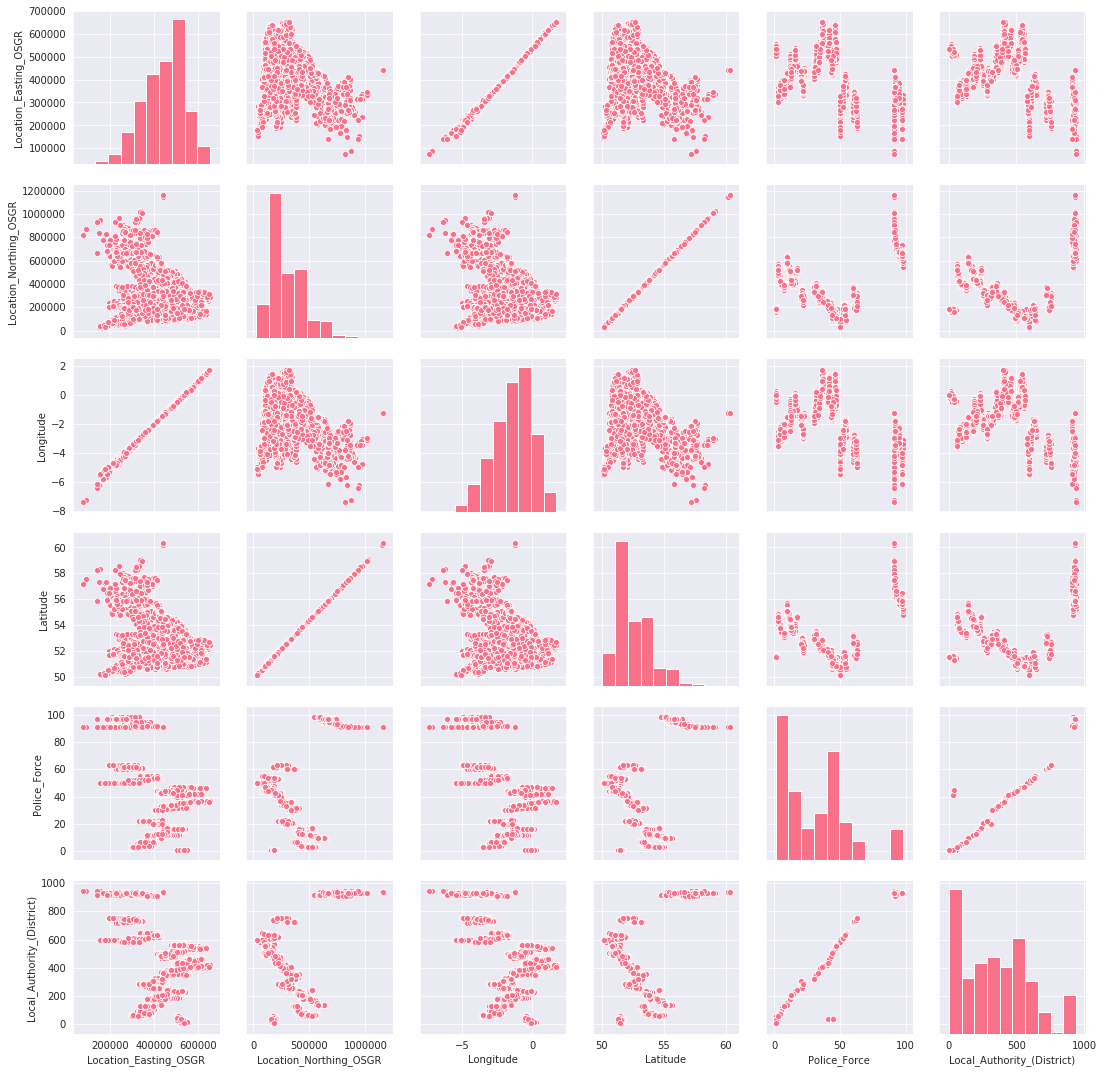

In [147]:
sns.pairplot(data=df_acc[['Location_Easting_OSGR', 
                            'Location_Northing_OSGR', 
                            'Longitude',
                            'Latitude',  
                            'Police_Force', 
                            'Local_Authority_(District)', 
                            'Local_Authority_(Highway)', 
                            'LSOA_of_Accident_Location',
                            ]].sample(frac = 0.1))

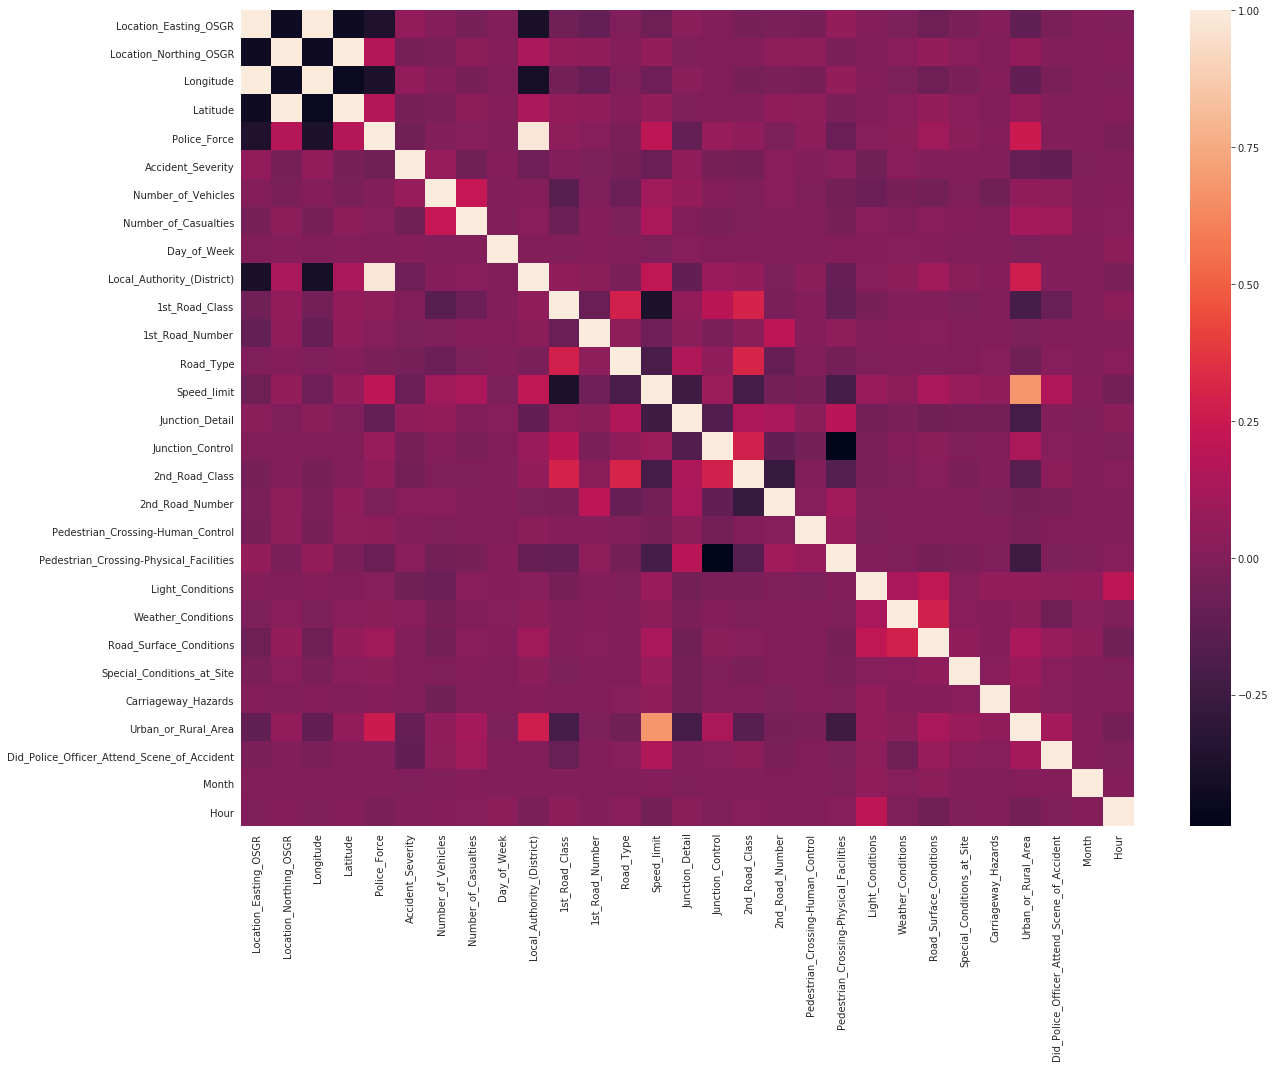

In [148]:
plt.figure(2, figsize=(20,15))
sns.heatmap(df_acc.corr())

### Feature Engineering

#### Time 

In [149]:
df_acc['Time_int'] = pd.to_datetime(df_acc.Time).astype(int)/10**9

In [150]:
df_acc['Date_int'] = pd.to_datetime(df_acc.Date).astype(int)/10**9

#### Building the rush hour

In [154]:
def rush_hour(hour):
    if hour >= 6 and hour < 9:
        return "6-9"
    elif hour >= 9 and hour < 16:
        return "9-16"
    elif hour >= 16 and hour < 19:
        return "16-19"
    elif hour >= 19 and hour < 22:
        return "19-22"
    else:
        return "22-6"
df_acc['Rush Hour'] = df_acc['Hour'].apply(rush_hour)
df_acc[['Time', 'Hour', 'Rush Hour']].head(8)

,Time,Hour,Rush Hour
0,13:21,13,9-16
1,23:00,23,22-6
2,10:40,10,9-16
3,17:45,17,16-19
4,08:50,8,6-9
5,14:11,14,9-16
6,18:25,18,16-19
7,17:50,17,16-19


#### Holidays and Shifted Holidays 

In [194]:
uk_holidays = holidays.UK()
uk_holidays['2014-01-01': '2014-12-31']

[datetime.date(2014, 1, 1),
 datetime.date(2014, 1, 2),
 datetime.date(2014, 3, 17),
 datetime.date(2014, 4, 18),
 datetime.date(2014, 4, 21),
 datetime.date(2014, 5, 5),
 datetime.date(2014, 5, 26),
 datetime.date(2014, 7, 12),
 datetime.date(2014, 8, 4),
 datetime.date(2014, 8, 25),
 datetime.date(2014, 11, 30),
 datetime.date(2014, 12, 25),
 datetime.date(2014, 12, 26)]

In [239]:
# creating holidays
df_acc['Holiday'] = [ i in uk_holidays for i in df_acc.Date]
#shifting the holidays
df_acc['Holiday-1'] = [ i in uk_holidays for i in df_acc.dt -pd.Timedelta(days=1)]
df_acc['Holiday-2'] = [ i in uk_holidays for i in df_acc.dt -pd.Timedelta(days=2)]
df_acc['Holiday+1'] = [ i in uk_holidays for i in df_acc.dt +pd.Timedelta(days=1)]
df_acc['Holiday+2'] = [ i in uk_holidays for i in df_acc.dt +pd.Timedelta(days=2)]

In [240]:
#check
df_acc.loc[df_acc.Date=='26/12/2014',['Date','Holiday','Holiday-1','Holiday-2',
                                      'Holiday+1','Holiday+2']]

,Date,Holiday,Holiday-1,Holiday-2,Holiday+1,Holiday+2
702,26/12/2014,True,True,False,False,False
1067,26/12/2014,True,True,False,False,False
2651,26/12/2014,True,True,False,False,False
2653,26/12/2014,True,True,False,False,False
2655,26/12/2014,True,True,False,False,False
2656,26/12/2014,True,True,False,False,False
2657,26/12/2014,True,True,False,False,False
2660,26/12/2014,True,True,False,False,False
2668,26/12/2014,True,True,False,False,False
3542,26/12/2014,True,True,False,False,False


#### Rounding the time to nearest half 15min

In [339]:
df_acc['Time_rounded'] = df_acc.dt.dt.round('30min').dt.time
df_acc['Time_rounded']

0         13:30:00
1         23:00:00
2         10:30:00
3         18:00:00
4         09:00:00
5         14:00:00
6         18:30:00
7         18:00:00
8         11:00:00
9         20:30:00
            ...   
146312    07:00:00
146313    15:30:00
146314    19:30:00
146315    03:00:00
146316    09:30:00
146317    22:30:00
146318    06:30:00
146319    02:00:00
146320    07:00:00
146321    15:00:00
Name: Time_rounded, Length: 146322, dtype: object

## Machine Learning 

In [340]:
df_acc.columns
# df_acc.isna().sum()

Index(['Accident_Index', 'Location_Easting_OSGR', 'Location_Northing_OSGR', 'Longitude', 'Latitude', 'Police_Force', 'Accident_Severity', 'Number_of_Vehicles', 'Number_of_Casualties', 'Date', 'Day_of_Week', 'Time', 'Local_Authority_(District)', 'Local_Authority_(Highway)', '1st_Road_Class', '1st_Road_Number', 'Road_Type', 'Speed_limit', 'Junction_Detail', 'Junction_Control', '2nd_Road_Class', '2nd_Road_Number', 'Pedestrian_Crossing-Human_Control', 'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions', 'Weather_Conditions', 'Road_Surface_Conditions', 'Special_Conditions_at_Site', 'Carriageway_Hazards', 'Urban_or_Rural_Area', 'Did_Police_Officer_Attend_Scene_of_Accident', 'LSOA_of_Accident_Location', 'dt', 'Month', 'Hour', 'Time_int', 'Date_int', 'Hour_int', 'Rush Hour', 'Holiday', 'Holiday-1', 'Holiday-2', 'Holiday+1', 'Holiday+2', 'Time_rounded'], dtype='object')

In [341]:
columns = [
 'Date', 
 'dt',
 'Location_Easting_OSGR', 
 'Location_Northing_OSGR', 
 'Longitude',
 'Latitude', 
 'Number_of_Vehicles', 
 'Number_of_Casualties',
 'Time_int',
 'Date_int',
 'Time',
 'Speed_limit', 
 'Day_of_Week',
 'Month', 
 'Hour',
 'Rush Hour',
 'Holiday',
 'Holiday-1',
 'Holiday-2',
 'Holiday+1',
 'Holiday+2',
 'Time_rounded',
 'Police_Force', 
 'Accident_Severity', 
 'Local_Authority_(District)', 
 'Local_Authority_(Highway)', 
 '1st_Road_Class', 
 '1st_Road_Number', 
 'Road_Type', 
 'Junction_Detail', 
 'Junction_Control', 
 '2nd_Road_Class',
 '2nd_Road_Number', 
 'Pedestrian_Crossing-Human_Control', 
 'Pedestrian_Crossing-Physical_Facilities', 
 'Light_Conditions', 
 'Weather_Conditions', 
 'Road_Surface_Conditions', 
 'Special_Conditions_at_Site', 
 'Carriageway_Hazards', 
 'Urban_or_Rural_Area', 
 'LSOA_of_Accident_Location', 
 'Did_Police_Officer_Attend_Scene_of_Accident'
]
len(columns)

43

In [342]:
#column types
column_types = ['time']*2 + \
               ['real']*8 + \
               ['enum' for _ in range(len(columns) - 10)] 
len(column_types)
for o in (zip(columns,column_types)):
    print(o)


('Date', 'time')
('dt', 'time')
('Location_Easting_OSGR', 'real')
('Location_Northing_OSGR', 'real')
('Longitude', 'real')
('Latitude', 'real')
('Number_of_Vehicles', 'real')
('Number_of_Casualties', 'real')
('Time_int', 'real')
('Date_int', 'real')
('Time', 'enum')
('Speed_limit', 'enum')
('Day_of_Week', 'enum')
('Month', 'enum')
('Hour', 'enum')
('Rush Hour', 'enum')
('Holiday', 'enum')
('Holiday-1', 'enum')
('Holiday-2', 'enum')
('Holiday+1', 'enum')
('Holiday+2', 'enum')
('Time_rounded', 'enum')
('Police_Force', 'enum')
('Accident_Severity', 'enum')
('Local_Authority_(District)', 'enum')
('Local_Authority_(Highway)', 'enum')
('1st_Road_Class', 'enum')
('1st_Road_Number', 'enum')
('Road_Type', 'enum')
('Junction_Detail', 'enum')
('Junction_Control', 'enum')
('2nd_Road_Class', 'enum')
('2nd_Road_Number', 'enum')
('Pedestrian_Crossing-Human_Control', 'enum')
('Pedestrian_Crossing-Physical_Facilities', 'enum')
('Light_Conditions', 'enum')
('Weather_Conditions', 'enum')
('Road_Surface_C

In [343]:
df=df_acc.sample(frac=1).reset_index(drop=True)[columns].copy()
train_df = df[:int(len(df)*0.8)]
test_df  = df[int(len(df)*0.8):]


#check the imbalance in test set
print (test_df.Did_Police_Officer_Attend_Scene_of_Accident.eq(1).sum(),
       test_df.Did_Police_Officer_Attend_Scene_of_Accident.eq(0).sum())
print ('Police attended in the {}% of cases'.
        format(round((test_df.Did_Police_Officer_Attend_Scene_of_Accident.eq(0).sum()/
                      len(test_df))
                                                     *100)))

23903 5362
Police attended in the 18.0% of cases


In [344]:
#check the imbalance in train set
print (train_df.Did_Police_Officer_Attend_Scene_of_Accident.eq(1).sum(),
       train_df.Did_Police_Officer_Attend_Scene_of_Accident.eq(0).sum())
print ('Police attended in the {}% of cases'.
        format(round((train_df.Did_Police_Officer_Attend_Scene_of_Accident.eq(0).sum()/
                      len(train_df))
                                                     *100)))

95704 21353
Police attended in the 18.0% of cases


In [345]:
# h2o.cluster().shutdown()
# h2o.remove_all()

In [346]:
## Import data into h2o
h2o.init(ip='localhost', nthreads=70, port=54321)
# h2o.connect(ip='192.168.0.31',  port=54321)


Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O cluster uptime:,3 hours 54 mins
H2O cluster timezone:,America/Chicago
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.0.1
H2O cluster version age:,24 days
H2O cluster name:,H2O_from_python_norayrm_nv6tai
H2O cluster total nodes:,1
H2O cluster free memory:,19.71 Gb
H2O cluster total cores:,72
H2O cluster allowed cores:,70
H2O cluster status:,"locked, healthy"


In [347]:
## import data to h2o
train_d = h2o.H2OFrame(train_df, column_types=column_types, destination_frame='train')
train,val = train_d.split_frame(ratios=[0.8])
# val = h2o.H2OFrame(val_pd,  column_types=column_types)
test = h2o.H2OFrame(test_df, column_types=column_types, destination_frame='test')

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [348]:
train.shape

(93559, 43)

In [406]:
## set predictors and response
predictors = train.columns[:-1]

# list of features to be removed
remove = [
#         'Date', 
#         'dt',
#         'Location_Easting_OSGR', 
#         'Location_Northing_OSGR', 
        'Longitude',
        'Latitude',
        'Local_Authority_(District)', 
        'Local_Authority_(Highway)',
        'LSOA_of_Accident_Location',
        '1st_Road_Number',
        '2nd_Road_Number',
#         'Time',
        'Time_rounded',
#         'Time_int',
#         'Police_Force',
          ]
for it in remove:
    predictors.remove(it)

response = 'Did_Police_Officer_Attend_Scene_of_Accident'
predictors

['Date',
 'dt',
 'Location_Easting_OSGR',
 'Location_Northing_OSGR',
 'Number_of_Vehicles',
 'Number_of_Casualties',
 'Time_int',
 'Date_int',
 'Time',
 'Speed_limit',
 'Day_of_Week',
 'Month',
 'Hour',
 'Rush Hour',
 'Holiday',
 'Holiday-1',
 'Holiday-2',
 'Holiday+1',
 'Holiday+2',
 'Police_Force',
 'Accident_Severity',
 '1st_Road_Class',
 'Road_Type',
 'Junction_Detail',
 'Junction_Control',
 '2nd_Road_Class',
 'Pedestrian_Crossing-Human_Control',
 'Pedestrian_Crossing-Physical_Facilities',
 'Light_Conditions',
 'Weather_Conditions',
 'Road_Surface_Conditions',
 'Special_Conditions_at_Site',
 'Carriageway_Hazards',
 'Urban_or_Rural_Area']

## GBM 

In [420]:
#######################################################################################
## GBM
# # Create and train GBM
model_gbm = H2OGradientBoostingEstimator(
    model_id="gbm_basic"
    ,balance_classes = True
    ,ntrees= 200 # 74
    ,max_depth=7
#     ,nfolds=5
    # ,fold_assignment='Sparse'
    ,score_tree_interval=10
    ,min_rows = 100
    ,distribution='bernoulli'
    ,sample_rate=0.8
    ,col_sample_rate=0.8
    ,col_sample_rate_per_tree=0.8
    ,learn_rate=0.08
    # ,stopping_tolerance=0.01 #10-fold increase in threshold as defined in rf_v1
    # ,stopping_rounds=0
    , stopping_metric="AUC"  #"misclassification" # "AUCPR" # "logloss" # 
    ,score_each_iteration=False
    # ,keep_cross_validation_predictions=True
    ,seed=4413976168041433600
)
t_start=time.time()
model_gbm.train(x=predictors, y=response, training_frame=train_d )#, validation_frame=val)
# model_gbm.train(x=predictors, y=response, training_frame=train, validation_frame=val)

tt=time.time()-t_start
print("Time to train (sec): ", tt)

gbm Model Build progress: |███████████████████████████████████████████████| 100%
Time to train (sec):  6.33813738822937


In [421]:
print( model_gbm.model_performance(test))


ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.12554174325442866
RMSE: 0.3543187029418976
LogLoss: 0.39638020582472533
Mean Per-Class Error: 0.28725113325189744
AUC: 0.7838936736461426
AUCPR: 0.9277558468876729
Gini: 0.5677873472922852

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.489065889993522: 


,,0,1,Error,Rate
0,0,533.0,4829.0,0.9006,(4829.0/5362.0)
1,1,274.0,23629.0,0.0115,(274.0/23903.0)
2,Total,807.0,28458.0,0.1744,(5103.0/29265.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.489066,0.902542,324.0
1,max f2,0.303226,0.957425,369.0
2,max f0point5,0.759783,0.876697,195.0
3,max accuracy,0.541425,0.827029,305.0
4,max precision,0.998809,1.000000,0.0
5,max recall,0.090087,1.000000,395.0
6,max specificity,0.998809,1.000000,0.0
7,max absolute_mcc,0.800517,0.343480,168.0
8,max min_per_class_accuracy,0.826079,0.709437,151.0
9,max mean_per_class_accuracy,0.845939,0.712749,137.0



Gains/Lift Table: Avg response rate: 81.68 %, avg score: 84.04 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010012,0.998349,1.224323,1.224323,1.000000,0.998838,1.000000,0.998838,0.012258,0.012258,22.432331,22.432331
1,,2,0.020024,0.997544,1.224323,1.224323,1.000000,0.997965,1.000000,0.998402,0.012258,0.024516,22.432331,22.432331
2,,3,0.030002,0.996734,1.224323,1.224323,1.000000,0.997140,1.000000,0.997982,0.012216,0.036732,22.432331,22.432331
3,,4,0.040014,0.995655,1.220145,1.223278,0.996587,0.996237,0.999146,0.997546,0.012216,0.048948,22.014473,22.327777
4,,5,0.050026,0.994168,1.220145,1.222651,0.996587,0.994952,0.998634,0.997026,0.012216,0.061164,22.014473,22.265073
5,,6,0.100017,0.986205,1.199218,1.210938,0.979494,0.990269,0.989067,0.993649,0.059951,0.121115,19.921757,21.093815
6,,7,0.150009,0.977643,1.180807,1.200897,0.964457,0.982067,0.980866,0.989789,0.059030,0.180145,18.080669,20.089662
7,,8,0.200000,0.968081,1.183317,1.196503,0.966507,0.972923,0.977277,0.985573,0.059156,0.239301,18.331726,19.650253
8,,9,0.300017,0.945192,1.160326,1.184442,0.947728,0.956980,0.967426,0.976041,0.116052,0.355353,16.032554,18.444216
9,,10,0.400000,0.916637,1.120971,1.168577,0.915584,0.931627,0.954468,0.964940,0.112078,0.467431,12.097134,16.857717


gbm prediction progress: |████████████████████████████████████████████████| 100%


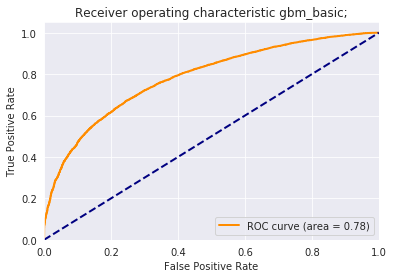

gbm prediction progress: |████████████████████████████████████████████████| 100%


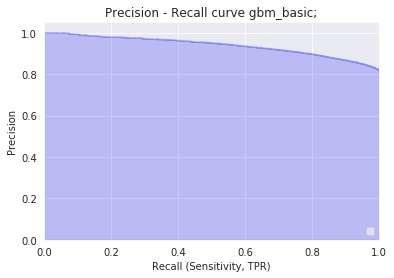

gbm prediction progress: |████████████████████████████████████████████████| 100%


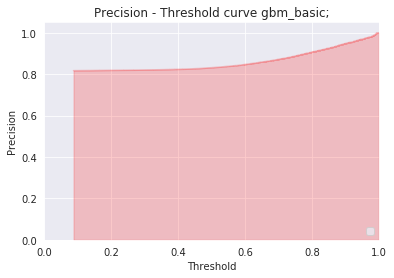

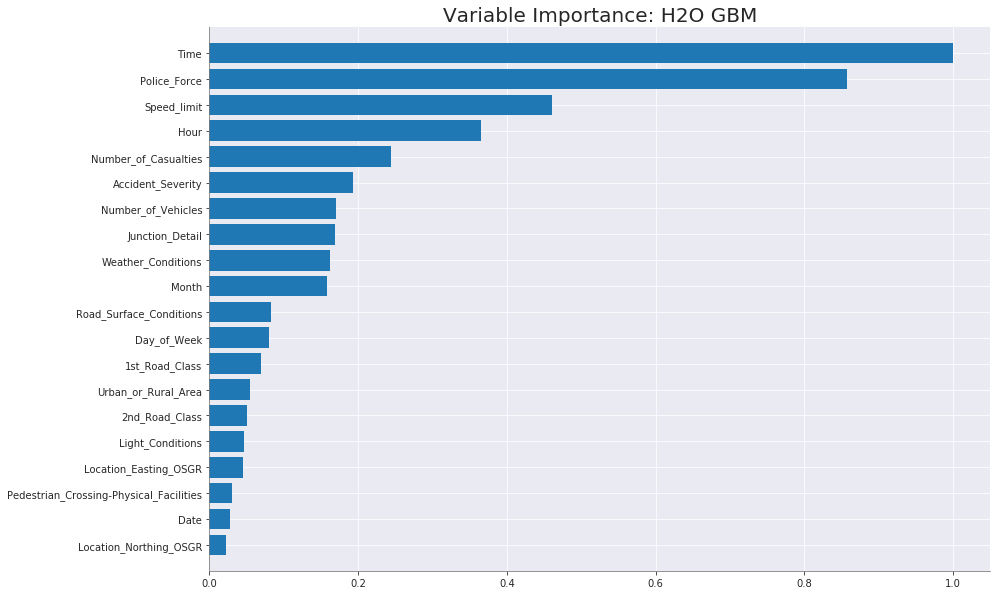

In [411]:
pred_gbm=draw_roc(test,model_gbm,False)

pr=draw_prec_recall(test,model_gbm,False)
pt=draw_prec_thr(test,model_gbm,False)


# Drav variable importances from h2o
model_gbm.varimp_plot(20)

In [412]:
# Print variable importance list
[[i[0],round(i[2],2)] for i in model_gbm.varimp()]

[['Time', 1.0],
 ['Police_Force', 0.86],
 ['Speed_limit', 0.46],
 ['Hour', 0.37],
 ['Number_of_Casualties', 0.24],
 ['Accident_Severity', 0.19],
 ['Number_of_Vehicles', 0.17],
 ['Junction_Detail', 0.17],
 ['Weather_Conditions', 0.16],
 ['Month', 0.16],
 ['Road_Surface_Conditions', 0.08],
 ['Day_of_Week', 0.08],
 ['1st_Road_Class', 0.07],
 ['Urban_or_Rural_Area', 0.05],
 ['2nd_Road_Class', 0.05],
 ['Light_Conditions', 0.05],
 ['Location_Easting_OSGR', 0.05],
 ['Pedestrian_Crossing-Physical_Facilities', 0.03],
 ['Date', 0.03],
 ['Location_Northing_OSGR', 0.02],
 ['Road_Type', 0.02],
 ['Junction_Control', 0.02],
 ['Date_int', 0.02],
 ['dt', 0.01],
 ['Rush Hour', 0.01],
 ['Special_Conditions_at_Site', 0.01],
 ['Time_int', 0.01],
 ['Carriageway_Hazards', 0.01],
 ['Holiday+2', 0.0],
 ['Holiday-2', 0.0],
 ['Holiday', 0.0],
 ['Pedestrian_Crossing-Human_Control', 0.0],
 ['Holiday+1', 0.0],
 ['Holiday-1', 0.0]]

In [413]:
################################################################################################
# real_v= pred_df.if_failed
real_v = test['Did_Police_Officer_Attend_Scene_of_Accident'].as_data_frame().values
pred_gbm = model_gbm.predict(test)
p_yes_gbm = pred_gbm.as_data_frame()['p1']

# pred_gbm=draw_roc(test,model_gbm,False)

for t in range(100,800,5):
    print_stats(t/1000,real_v, p_yes_gbm)
    print(' \n ')

gbm prediction progress: |████████████████████████████████████████████████| 100%
Accuracy =  81.69999999999999
Precsision =  0.817
Sensitivity =  1.0
Specificity =  0.002
NPV =  0.917
F1 =  0.9
MCC =  0.0384
Threshold =  0.1
[[   11  5351]
 [    1 23902]]
 
 
Accuracy =  81.69999999999999
Precsision =  0.817
Sensitivity =  1.0
Specificity =  0.003
NPV =  0.933
F1 =  0.9
MCC =  0.0439
Threshold =  0.105
[[   14  5348]
 [    1 23902]]
 
 
Accuracy =  81.69999999999999
Precsision =  0.817
Sensitivity =  1.0
Specificity =  0.003
NPV =  0.882
F1 =  0.9
MCC =  0.0436
Threshold =  0.11
[[   15  5347]
 [    2 23901]]
 
 
Accuracy =  81.69999999999999
Precsision =  0.817
Sensitivity =  1.0
Specificity =  0.003
NPV =  0.9
F1 =  0.9
MCC =  0.0485
Threshold =  0.115
[[   18  5344]
 [    2 23901]]
 
 
Accuracy =  81.69999999999999
Precsision =  0.817
Sensitivity =  1.0
Specificity =  0.004
NPV =  0.909
F1 =  0.9
MCC =  0.0515
Threshold =  0.12
[[   20  5342]
 [    2 23901]]
 
 
Accuracy =  81.69999

 [   30 23873]]
 
 
Accuracy =  82.1
Precsision =  0.821
Sensitivity =  0.999
Specificity =  0.031
NPV =  0.842
F1 =  0.9
MCC =  0.1398
Threshold =  0.335
[[  165  5197]
 [   31 23872]]
 
 
Accuracy =  82.1
Precsision =  0.821
Sensitivity =  0.999
Specificity =  0.031
NPV =  0.832
F1 =  0.9
MCC =  0.1397
Threshold =  0.34
[[  168  5194]
 [   34 23869]]
 
 
Accuracy =  82.1
Precsision =  0.821
Sensitivity =  0.998
Specificity =  0.032
NPV =  0.828
F1 =  0.9
MCC =  0.1413
Threshold =  0.345
[[  173  5189]
 [   36 23867]]
 
 
Accuracy =  82.1
Precsision =  0.822
Sensitivity =  0.998
Specificity =  0.034
NPV =  0.811
F1 =  0.9
MCC =  0.1418
Threshold =  0.35
[[  180  5182]
 [   42 23861]]
 
 
Accuracy =  82.19999999999999
Precsision =  0.822
Sensitivity =  0.998
Specificity =  0.035
NPV =  0.81
F1 =  0.9
MCC =  0.1449
Threshold =  0.355
[[  188  5174]
 [   44 23859]]
 
 
Accuracy =  82.19999999999999
Precsision =  0.822
Sensitivity =  0.998
Specificity =  0.036
NPV =  0.805
F1 =  0.9
MCC =

Threshold =  0.565
[[  950  4412]
 [  669 23234]]
 
 
Accuracy =  82.6
Precsision =  0.841
Sensitivity =  0.97
Specificity =  0.182
NPV =  0.58
F1 =  0.9
MCC =  0.2534
Threshold =  0.57
[[  977  4385]
 [  708 23195]]
 
 
Accuracy =  82.5
Precsision =  0.842
Sensitivity =  0.968
Specificity =  0.187
NPV =  0.57
F1 =  0.9
MCC =  0.2532
Threshold =  0.575
[[ 1005  4357]
 [  758 23145]]
 
 
Accuracy =  82.5
Precsision =  0.843
Sensitivity =  0.967
Specificity =  0.195
NPV =  0.568
F1 =  0.9
MCC =  0.2576
Threshold =  0.58
[[ 1046  4316]
 [  797 23106]]
 
 
Accuracy =  82.5
Precsision =  0.843
Sensitivity =  0.965
Specificity =  0.201
NPV =  0.562
F1 =  0.9
MCC =  0.2592
Threshold =  0.585
[[ 1077  4285]
 [  839 23064]]
 
 
Accuracy =  82.5
Precsision =  0.845
Sensitivity =  0.963
Specificity =  0.211
NPV =  0.563
F1 =  0.9
MCC =  0.2668
Threshold =  0.59
[[ 1134  4228]
 [  881 23022]]
 
 
Accuracy =  82.5
Precsision =  0.846
Sensitivity =  0.961
Specificity =  0.219
NPV =  0.557
F1 =  0.9


In [422]:
print_stats(0.800517,real_v, p_yes_gbm)

Accuracy =  74.0
Precsision =  0.907
Sensitivity =  0.759
Specificity =  0.654
NPV =  0.378
F1 =  0.83
MCC =  0.3433
Threshold =  0.795
[[ 3507  1855]
 [ 5765 18138]]


Confusion matrix, without normalization
[[  435  4927]
 [  215 23688]]


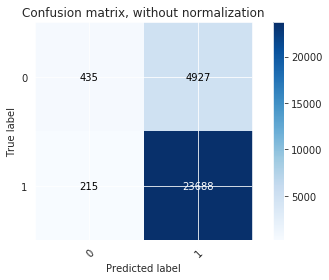

In [415]:
plot_confusion_matrix(0.4688,real_v,  pred_gbm.as_data_frame()['p1'], [0,1])
# pred_gbm

In [416]:
# Print the precision and recall, among other metrics
print(metrics.classification_report(real_v, pred_gbm.as_data_frame()['predict'], digits=3))

              precision    recall  f1-score   support

           0      0.388     0.620     0.478      5362
           1      0.902     0.781     0.837     23903

   micro avg      0.752     0.752     0.752     29265
   macro avg      0.645     0.700     0.657     29265
weighted avg      0.808     0.752     0.771     29265



In [417]:
print('                 0         1 \n',
'precision', metrics.classification.precision_score(real_v, pred_gbm.as_data_frame()['predict'],
                                       labels=[0,1],average=None),'\n',
'recall   ', metrics.classification.recall_score(real_v, pred_gbm.as_data_frame()['predict'],
                                       labels=[0,1],average=None)
     )

                 0         1 
 precision [0.38847323 0.9015499 ] 
 recall    [0.61973144 0.78115718]


## XGBoost

In [456]:
## set predictors and response
predictors = train.columns[:-1]

remove = [
#         'Date', 
#         'dt',
#         'Location_Easting_OSGR', 
#         'Location_Northing_OSGR', 
        'Longitude',
        'Latitude',
#         'Local_Authority_(District)', 
#         'Local_Authority_(Highway)',
        'LSOA_of_Accident_Location',
        '1st_Road_Number',
        '2nd_Road_Number',
        'Time',
#         'Time_rounded',
#         'Time_int',
#         'Police_Force',
#          'Weather_Conditions',
          ]
for it in remove:
    predictors.remove(it)

response = 'Did_Police_Officer_Attend_Scene_of_Accident'
predictors

['Date',
 'dt',
 'Location_Easting_OSGR',
 'Location_Northing_OSGR',
 'Number_of_Vehicles',
 'Number_of_Casualties',
 'Time_int',
 'Date_int',
 'Speed_limit',
 'Day_of_Week',
 'Month',
 'Hour',
 'Rush Hour',
 'Holiday',
 'Holiday-1',
 'Holiday-2',
 'Holiday+1',
 'Holiday+2',
 'Time_rounded',
 'Police_Force',
 'Accident_Severity',
 'Local_Authority_(District)',
 'Local_Authority_(Highway)',
 '1st_Road_Class',
 'Road_Type',
 'Junction_Detail',
 'Junction_Control',
 '2nd_Road_Class',
 'Pedestrian_Crossing-Human_Control',
 'Pedestrian_Crossing-Physical_Facilities',
 'Light_Conditions',
 'Weather_Conditions',
 'Road_Surface_Conditions',
 'Special_Conditions_at_Site',
 'Carriageway_Hazards',
 'Urban_or_Rural_Area']

xgboost Model Build progress: |███████████████████████████████████████████| 100%
Time to train (sec):  96.89741325378418
xgboost prediction progress: |████████████████████████████████████████████| 100%


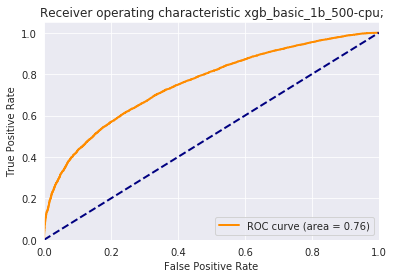

In [457]:

################################################################################################
## xgboost on cpu
model_xgb = H2OXGBoostEstimator(
#     balance_classes = True,
#     categorical_encoding='one_hot_explicit',
    model_id="xgb_basic_1b_500-cpu",
    ntrees=500
    ,max_depth=15
    ,tree_method='exact'
    # ,max_abs_leafnode_pred = 0.5
    # ,nfolds=5
    # ,fold_assignment='Modulo'
    ,score_tree_interval=5
    ,min_rows = 50
    ,distribution='bernoulli'
    ,sample_rate=1
    ,col_sample_rate=1
    ,col_sample_rate_per_tree=1
    ,learn_rate=0.02
    ,stopping_rounds=10
    ,stopping_tolerance=0.0001
    ,stopping_metric="AUC" #"misclassification" #"logloss" #"misclassification" # "AUCPR"  #   "AUC" #
    ,score_each_iteration=False
    # ,keep_cross_validation_predictions=True
    ,seed=4413976168041433600
    ,backend='cpu'
)

t_start=time.time()
# model_xgb.train(x=predictors, y=response, training_frame=train_d ) #training_frame=train, validation_frame=val)
model_xgb.train(x=predictors, y=response, training_frame=train, validation_frame=val)

tt=time.time()-t_start
print("Time to train (sec): ", tt)

prediction_BOOL_xgb=draw_roc(test,model_xgb,False)

In [458]:
print( model_xgb.model_performance(test))


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.13017023267956956
RMSE: 0.3607911205664152
LogLoss: 0.4099339526990189
Mean Per-Class Error: 0.31388712692038934
AUC: 0.755272541516367
AUCPR: 0.9289937233300577
Gini: 0.510545083032734

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.43325071334838866: 


,,0,1,Error,Rate
0,0,274.0,5088.0,0.9489,(5088.0/5362.0)
1,1,101.0,23802.0,0.0042,(101.0/23903.0)
2,Total,375.0,28890.0,0.1773,(5189.0/29265.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.433251,0.901710,347.0
1,max f2,0.238695,0.957195,378.0
2,max f0point5,0.685839,0.867746,241.0
3,max accuracy,0.514937,0.823168,322.0
4,max precision,0.992001,1.000000,0.0
5,max recall,0.076774,1.000000,399.0
6,max specificity,0.992001,1.000000,0.0
7,max absolute_mcc,0.786552,0.294180,174.0
8,max min_per_class_accuracy,0.802832,0.681089,162.0
9,max mean_per_class_accuracy,0.833471,0.686113,138.0



Gains/Lift Table: Avg response rate: 81.68 %, avg score: 81.82 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010012,0.988590,1.224323,1.224323,1.000000,0.990048,1.000000,0.990048,0.012258,0.012258,22.432331,22.432331
1,,2,0.020024,0.986784,1.224323,1.224323,1.000000,0.987660,1.000000,0.988854,0.012258,0.024516,22.432331,22.432331
2,,3,0.030002,0.984952,1.211745,1.220140,0.989726,0.985840,0.996583,0.987852,0.012091,0.036606,21.174464,22.013997
3,,4,0.040014,0.982765,1.207609,1.217005,0.986348,0.983897,0.994022,0.986862,0.012091,0.048697,20.760900,21.700455
4,,5,0.050026,0.980407,1.215966,1.216797,0.993174,0.981716,0.993852,0.985832,0.012174,0.060871,21.596615,21.679673
5,,6,0.100017,0.968659,1.202565,1.209683,0.982228,0.974562,0.988042,0.980199,0.060118,0.120989,20.256500,20.968329
6,,7,0.150009,0.956922,1.183317,1.200897,0.966507,0.962828,0.980866,0.974410,0.059156,0.180145,18.331726,20.089662
7,,8,0.200000,0.943365,1.170764,1.193365,0.956254,0.950306,0.974714,0.968385,0.058528,0.238673,17.076439,19.336485
8,,9,0.300017,0.912014,1.142758,1.176494,0.933379,0.928045,0.960934,0.954937,0.114295,0.352968,14.275752,17.649382
9,,10,0.400000,0.879651,1.094610,1.156026,0.894053,0.895875,0.944217,0.940174,0.109442,0.462411,9.461031,15.602644


xgboost prediction progress: |████████████████████████████████████████████| 100%


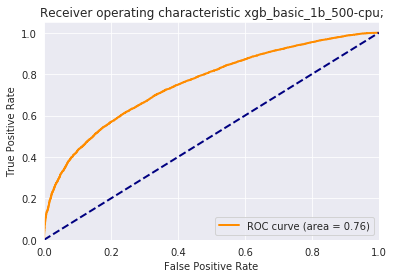

xgboost prediction progress: |████████████████████████████████████████████| 100%


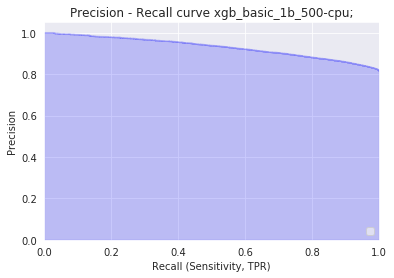

xgboost prediction progress: |████████████████████████████████████████████| 100%


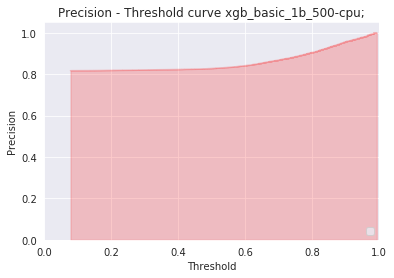

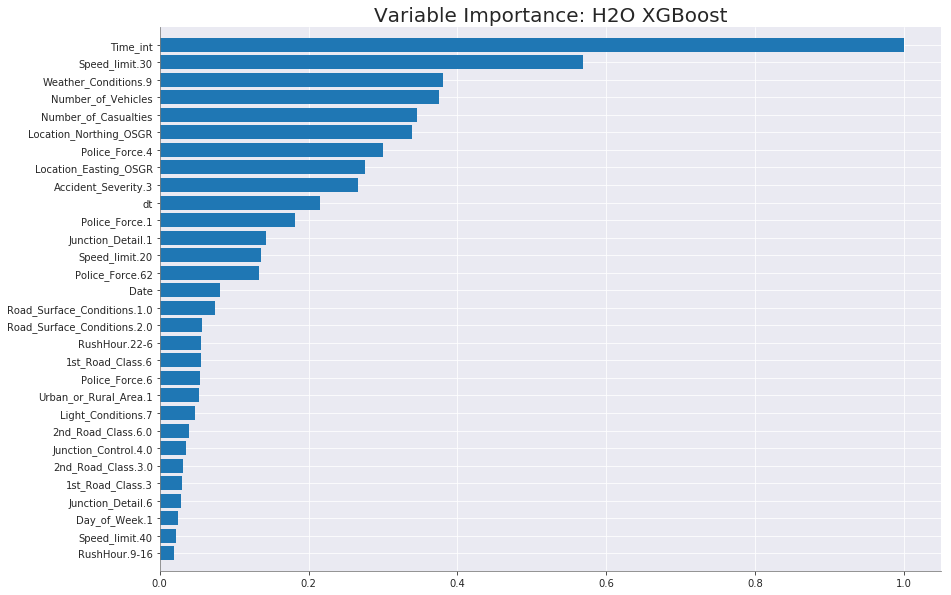

In [459]:
pred_gbm=draw_roc(test,model_xgb,False)

pr=draw_prec_recall(test,model_xgb,False)
pt=draw_prec_thr(test,model_xgb,False)


# Drav variable importances from h2o
model_xgb.varimp_plot(30)

In [460]:
# Print variable importance list
[[i[0],round(i[2],1)] for i in model_xgb.varimp()]

[['Time_int', 1.0],
 ['Speed_limit.30', 0.6],
 ['Weather_Conditions.9', 0.4],
 ['Number_of_Vehicles', 0.4],
 ['Number_of_Casualties', 0.3],
 ['Location_Northing_OSGR', 0.3],
 ['Police_Force.4', 0.3],
 ['Location_Easting_OSGR', 0.3],
 ['Accident_Severity.3', 0.3],
 ['dt', 0.2],
 ['Police_Force.1', 0.2],
 ['Junction_Detail.1', 0.1],
 ['Speed_limit.20', 0.1],
 ['Police_Force.62', 0.1],
 ['Date', 0.1],
 ['Road_Surface_Conditions.1.0', 0.1],
 ['Road_Surface_Conditions.2.0', 0.1],
 ['RushHour.22-6', 0.1],
 ['1st_Road_Class.6', 0.1],
 ['Police_Force.6', 0.1],
 ['Urban_or_Rural_Area.1', 0.1],
 ['Light_Conditions.7', 0.0],
 ['2nd_Road_Class.6.0', 0.0],
 ['Junction_Control.4.0', 0.0],
 ['2nd_Road_Class.3.0', 0.0],
 ['1st_Road_Class.3', 0.0],
 ['Junction_Detail.6', 0.0],
 ['Day_of_Week.1', 0.0],
 ['Speed_limit.40', 0.0],
 ['RushHour.9-16', 0.0],
 ['Junction_Detail.3', 0.0],
 ['Speed_limit.70', 0.0],
 ['Light_Conditions.6', 0.0],
 ['Road_Type.6', 0.0],
 ['Hour.18', 0.0],
 ['Light_Conditions.4', 0.

In [461]:
################################################################################################
# real_v= pred_df.if_failed
real_v = test['Did_Police_Officer_Attend_Scene_of_Accident'].as_data_frame().values
pred_xgb = model_xgb.predict(test)
p_yes_xgb = pred_xgb.as_data_frame()['p1']

# pred_gbm=draw_roc(test,model_gbm,False)

for t in range(100,800,5):
    print_stats(t/1000,real_v, p_yes_xgb)
    print(' \n ')

xgboost prediction progress: |████████████████████████████████████████████| 100%
Accuracy =  81.69999999999999
Precsision =  0.817
Sensitivity =  1.0
Specificity =  0.001
NPV =  0.667
F1 =  0.9
MCC =  0.0179
Threshold =  0.1
[[    4  5358]
 [    2 23901]]
 
 
Accuracy =  81.69999999999999
Precsision =  0.817
Sensitivity =  1.0
Specificity =  0.001
NPV =  0.667
F1 =  0.9
MCC =  0.0179
Threshold =  0.105
[[    4  5358]
 [    2 23901]]
 
 
Accuracy =  81.69999999999999
Precsision =  0.817
Sensitivity =  1.0
Specificity =  0.001
NPV =  0.714
F1 =  0.9
MCC =  0.0212
Threshold =  0.11
[[    5  5357]
 [    2 23901]]
 
 
Accuracy =  81.69999999999999
Precsision =  0.817
Sensitivity =  1.0
Specificity =  0.001
NPV =  0.778
F1 =  0.9
MCC =  0.027
Threshold =  0.115
[[    7  5355]
 [    2 23901]]
 
 
Accuracy =  81.69999999999999
Precsision =  0.817
Sensitivity =  1.0
Specificity =  0.001
NPV =  0.8
F1 =  0.9
MCC =  0.0295
Threshold =  0.12
[[    8  5354]
 [    2 23901]]
 
 
Accuracy =  81.699999

Specificity =  0.031
NPV =  0.8
F1 =  0.9
MCC =  0.1339
Threshold =  0.33
[[  164  5198]
 [   41 23862]]
 
 
Accuracy =  82.1
Precsision =  0.821
Sensitivity =  0.998
Specificity =  0.031
NPV =  0.796
F1 =  0.9
MCC =  0.135
Threshold =  0.335
[[  168  5194]
 [   43 23860]]
 
 
Accuracy =  82.1
Precsision =  0.821
Sensitivity =  0.998
Specificity =  0.032
NPV =  0.8
F1 =  0.9
MCC =  0.1372
Threshold =  0.34
[[  172  5190]
 [   43 23860]]
 
 
Accuracy =  82.1
Precsision =  0.822
Sensitivity =  0.998
Specificity =  0.033
NPV =  0.799
F1 =  0.9
MCC =  0.1398
Threshold =  0.345
[[  179  5183]
 [   45 23858]]
 
 
Accuracy =  82.1
Precsision =  0.822
Sensitivity =  0.998
Specificity =  0.034
NPV =  0.794
F1 =  0.9
MCC =  0.1399
Threshold =  0.35
[[  181  5181]
 [   47 23856]]
 
 
Accuracy =  82.1
Precsision =  0.822
Sensitivity =  0.998
Specificity =  0.035
NPV =  0.777
F1 =  0.9
MCC =  0.1391
Threshold =  0.355
[[  185  5177]
 [   53 23850]]
 
 
Accuracy =  82.1
Precsision =  0.822
Sensitivi

NPV =  0.535
F1 =  0.9
MCC =  0.2077
Threshold =  0.565
[[  776  4586]
 [  674 23229]]
 
 
Accuracy =  82.0
Precsision =  0.836
Sensitivity =  0.97
Specificity =  0.149
NPV =  0.528
F1 =  0.9
MCC =  0.2083
Threshold =  0.57
[[  800  4562]
 [  715 23188]]
 
 
Accuracy =  81.89999999999999
Precsision =  0.836
Sensitivity =  0.968
Specificity =  0.155
NPV =  0.524
F1 =  0.9
MCC =  0.211
Threshold =  0.575
[[  831  4531]
 [  754 23149]]
 
 
Accuracy =  81.89999999999999
Precsision =  0.837
Sensitivity =  0.966
Specificity =  0.163
NPV =  0.52
F1 =  0.9
MCC =  0.2149
Threshold =  0.58
[[  874  4488]
 [  807 23096]]
 
 
Accuracy =  81.89999999999999
Precsision =  0.838
Sensitivity =  0.964
Specificity =  0.172
NPV =  0.517
F1 =  0.9
MCC =  0.2197
Threshold =  0.585
[[  920  4442]
 [  858 23045]]
 
 
Accuracy =  81.8
Precsision =  0.839
Sensitivity =  0.962
Specificity =  0.179
NPV =  0.511
F1 =  0.9
MCC =  0.2224
Threshold =  0.59
[[  962  4400]
 [  919 22984]]
 
 
Accuracy =  81.69999999999

In [462]:
print_stats(0.775,real_v, p_yes_xgb)

Accuracy =  72.0
Precsision =  0.894
Sensitivity =  0.745
Specificity =  0.608
NPV =  0.348
F1 =  0.81
MCC =  0.2926
Threshold =  0.795
[[ 3260  2102]
 [ 6099 17804]]


In [468]:
test[['Time','Time_int']]

Time,Time_int
08:12,1.57864e+09
14:30,1.57867e+09
18:20,1.57868e+09
12:10,1.57866e+09
19:40,1.57869e+09
18:38,1.57868e+09
11:10,1.57865e+09
12:30,1.57866e+09
07:20,1.57864e+09
13:55,1.57866e+09


### Auto Machine Learning

In [375]:
########################################################################################
# Run AutoML for 30 mins
aml = H2OAutoML(max_runtime_secs = 1800)
aml.train(x=predictors, y=response, training_frame= train, #validation_frame=val,
          leaderboard_frame = test)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb
#



AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_AutoML_20200110_135544,0.752299,0.416181,0.921886,0.474185,0.362581,0.131465
StackedEnsemble_BestOfFamily_AutoML_20200110_135544,0.752136,0.417332,0.920249,0.47736,0.36305,0.131805
XGBoost_1_AutoML_20200110_135544,0.751441,0.411453,0.919121,0.474105,0.361772,0.130879
XGBoost_2_AutoML_20200110_135544,0.750331,0.411749,0.923344,0.469572,0.361711,0.130835
XGBoost_grid__1_AutoML_20200110_135544_model_1,0.74788,0.413152,0.903065,0.481125,0.362476,0.131389
XGBoost_grid__1_AutoML_20200110_135544_model_3,0.746247,0.41421,0.906898,0.481861,0.36298,0.131754
GBM_grid__1_AutoML_20200110_135544_model_6,0.744992,0.41524,0.926705,0.482687,0.362884,0.131685
XGBoost_3_AutoML_20200110_135544,0.744842,0.415455,0.925303,0.480816,0.363461,0.132104
GBM_grid__1_AutoML_20200110_135544_model_1,0.744286,0.415723,0.925718,0.477466,0.363012,0.131778
XGBoost_grid__1_AutoML_20200110_135544_model_2,0.743357,0.416127,0.925085,0.479699,0.363775,0.132332


In [376]:
lb

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_AllModels_AutoML_20200110_135544,0.752299,0.416181,0.921886,0.474185,0.362581,0.131465
StackedEnsemble_BestOfFamily_AutoML_20200110_135544,0.752136,0.417332,0.920249,0.47736,0.36305,0.131805
XGBoost_1_AutoML_20200110_135544,0.751441,0.411453,0.919121,0.474105,0.361772,0.130879
XGBoost_2_AutoML_20200110_135544,0.750331,0.411749,0.923344,0.469572,0.361711,0.130835
XGBoost_grid__1_AutoML_20200110_135544_model_1,0.74788,0.413152,0.903065,0.481125,0.362476,0.131389
XGBoost_grid__1_AutoML_20200110_135544_model_3,0.746247,0.41421,0.906898,0.481861,0.36298,0.131754
GBM_grid__1_AutoML_20200110_135544_model_6,0.744992,0.41524,0.926705,0.482687,0.362884,0.131685
XGBoost_3_AutoML_20200110_135544,0.744842,0.415455,0.925303,0.480816,0.363461,0.132104
GBM_grid__1_AutoML_20200110_135544_model_1,0.744286,0.415723,0.925718,0.477466,0.363012,0.131778
XGBoost_grid__1_AutoML_20200110_135544_model_2,0.743357,0.416127,0.925085,0.479699,0.363775,0.132332


stackedensemble prediction progress: |████████████████████████████████████| 100%


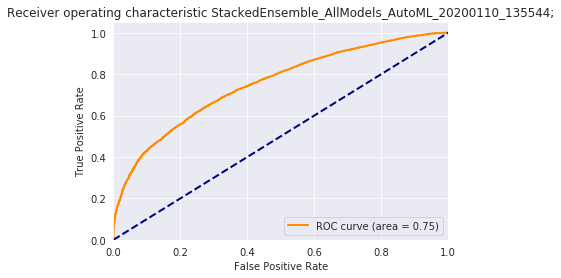

stackedensemble prediction progress: |████████████████████████████████████| 100%


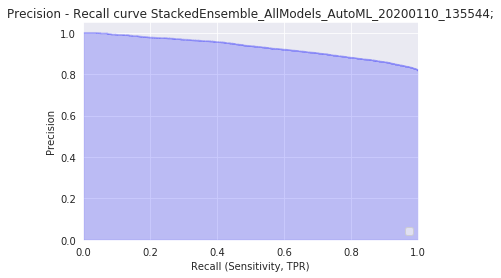

stackedensemble prediction progress: |████████████████████████████████████| 100%


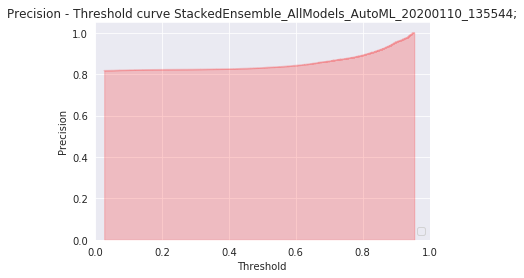

TypeError: 'NoneType' object is not iterable

In [377]:
pred_aml=draw_roc(test,aml.leader,False)
pred_aml=draw_prec_recall(test,aml.leader,False)
pred_aml=draw_prec_thr(test,aml.leader,False)


# Drav variable importances from h2o
aml.leader.varimp_plot(20)

## GLM

glm Model Build progress: |███████████████████████████████████████████████| 100%
Time to train (sec):  0.4872734546661377
glm prediction progress: |████████████████████████████████████████████████| 100%


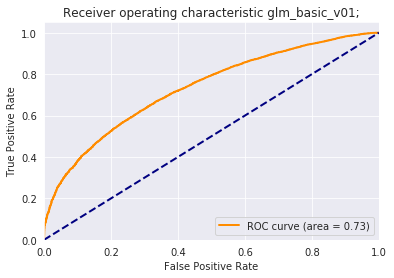

In [378]:

## Starting GLM

model_glm = H2OGeneralizedLinearEstimator(
    # balance_classes = True,
    # categorical_encoding='one_hot_explicit',
    max_iterations= 1000,
    early_stopping = False,
    objective_epsilon= 0.000001,
    alpha=0.3,
    lambda_ = 1e-4,
    model_id="glm_basic_v01",
    family='binomial'
)
t_start=time.time()
model_glm.train(x=predictors, y=response, training_frame=train) #, validation_frame=val)
tt=time.time()-t_start
print("Time to train (sec): ", tt)

prediction_glm=draw_roc(test,model_glm,False)


In [379]:
print( model_glm.model_performance(test))


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.13360720878207039
RMSE: 0.36552319869205346
LogLoss: 0.4212822696745806
Null degrees of freedom: 29264
Residual degrees of freedom: 29067
Null deviance: 27874.832921706045
Residual deviance: 24657.651244053202
AIC: 25053.651244053202
AUC: 0.7323100577628315
AUCPR: 0.9191012761601268
Gini: 0.46462011552566307

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4474888654475207: 


,,0,1,Error,Rate
0,0,229.0,5133.0,0.9573,(5133.0/5362.0)
1,1,109.0,23794.0,0.0046,(109.0/23903.0)
2,Total,338.0,28927.0,0.1791,(5242.0/29265.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.447489,0.900776,350.0
1,max f2,0.219411,0.957155,385.0
2,max f0point5,0.709856,0.863105,237.0
3,max accuracy,0.451098,0.820878,349.0
4,max precision,0.999076,1.000000,0.0
5,max recall,0.055885,1.000000,399.0
6,max specificity,0.999076,1.000000,0.0
7,max absolute_mcc,0.802426,0.264244,168.0
8,max min_per_class_accuracy,0.802426,0.665796,168.0
9,max mean_per_class_accuracy,0.802426,0.666831,168.0



Gains/Lift Table: Avg response rate: 81.68 %, avg score: 81.79 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010012,0.995928,1.224323,1.224323,1.000000,0.997675,1.000000,0.997675,0.012258,0.012258,22.432331,22.432331
1,,2,0.020024,0.992522,1.220145,1.222234,0.996587,0.994277,0.998294,0.995976,0.012216,0.024474,22.014473,22.223402
2,,3,0.030002,0.989168,1.215938,1.220140,0.993151,0.990880,0.996583,0.994281,0.012132,0.036606,21.593753,22.013997
3,,4,0.040014,0.986112,1.220145,1.220141,0.996587,0.987697,0.996584,0.992634,0.012216,0.048822,22.014473,22.014116
4,,5,0.050026,0.982684,1.215966,1.219306,0.993174,0.984406,0.995902,0.990987,0.012174,0.060997,21.596615,21.930559
5,,6,0.100017,0.963272,1.186665,1.202991,0.969241,0.972845,0.982576,0.981919,0.059323,0.120320,18.666470,20.299072
6,,7,0.150009,0.946257,1.168254,1.191414,0.954204,0.954616,0.973121,0.972820,0.058403,0.178722,16.825382,19.141439
7,,8,0.200000,0.930253,1.159048,1.183324,0.946685,0.938136,0.966513,0.964150,0.057943,0.236665,15.904838,18.332427
8,,9,0.300017,0.899557,1.115151,1.160597,0.910830,0.914623,0.947950,0.947639,0.111534,0.348199,11.515064,16.059714
9,,10,0.400000,0.869168,1.083731,1.141384,0.885167,0.884624,0.932257,0.931888,0.108355,0.456554,8.373116,14.138393


glm prediction progress: |████████████████████████████████████████████████| 100%


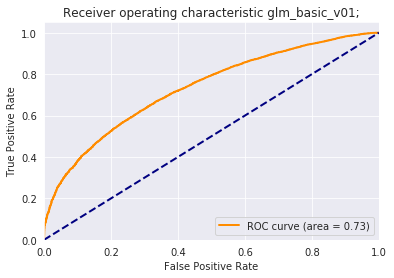

glm prediction progress: |████████████████████████████████████████████████| 100%


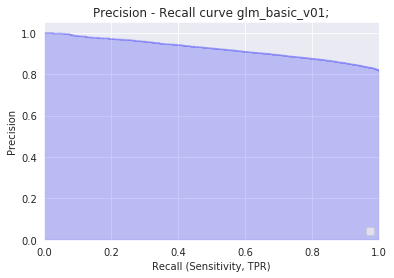

glm prediction progress: |████████████████████████████████████████████████| 100%


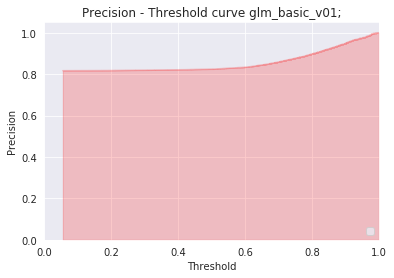

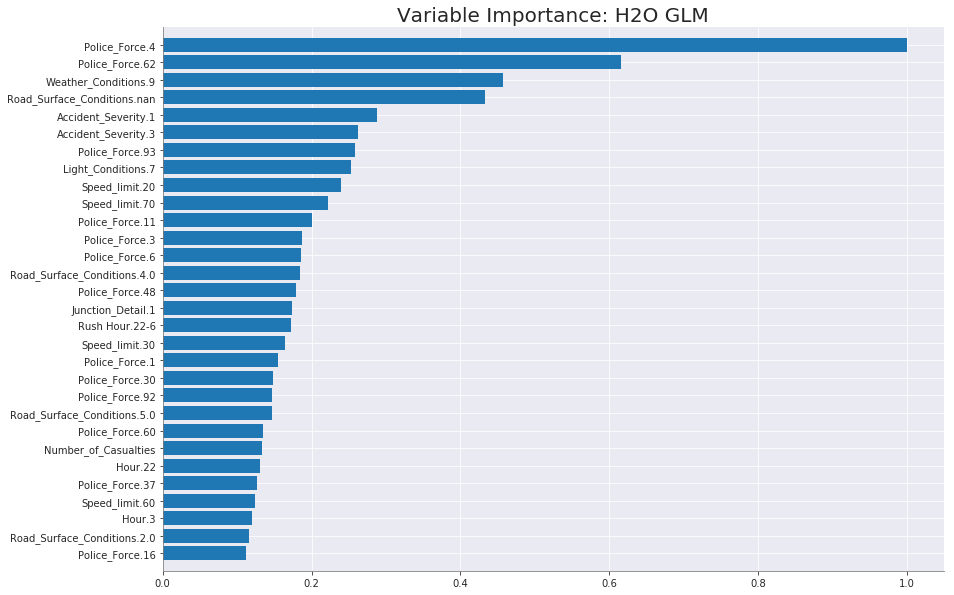

In [380]:
pred_gbm=draw_roc(test,model_glm,False)

pr=draw_prec_recall(test,model_glm,False)
pt=draw_prec_thr(test,model_glm,False)


# Drav variable importances from h2o
model_glm.varimp_plot(30)